<a href="https://colab.research.google.com/github/mylibui/demo/blob/master/AE_VAE_Modelle_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import datetime
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import os
import pandas as pd
from typing import Union, Tuple, Optional, List, Any,Dict

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path= '/content/drive/MyDrive/Data/creditcard.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

In [4]:
# Separate features and labels
X = df.drop(['Class'], axis=1).values
y = df['Class'].values


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Only use normal transactions for training (Class = 0)
X_train_normal = X_train[y_train == 0]

In [13]:
# Hyperparameters
input_dim = X_train.shape[1]
epoch=100
learning_rate=0.001
latent_dim=16
hidden_dims=[64,32]
dropout_rate=0.1
activation='mish'
batch_size=256
kl_weight=1
classifier_dim=[16,8]
callbacks=callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

]

#0. Hilffunktion definiern

## 1.Plot Verlustkurve

In [194]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Union, Optional, Tuple, List, Dict

def plot_loss_curves(
    history: Union[tf.keras.callbacks.History, Dict],
    model_type: str,
    figsize: Tuple[int, int] = (16, 8),
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/loss_curves"
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Plottet umfassende Loss-Kurven für verschiedene Autoencoder-Modelltypen (UnsupervisedAE, UnsupervisedVAE,
    SupervisedAE, SupervisedVAE) und speichert sie optional in einem Google Drive-Ordner.

    Args:
        history: Das History-Objekt aus dem `model.fit()`-Aufruf oder ein Dictionary mit Metriken.
        model_type: Typ des Modells ('uae', 'uvae', 'sae', 'svae'). Standardwert ist 'uae'.
        figsize: Größe der Abbildung als Tuple (Breite, Höhe). Standardwert ist (16, 10).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/loss_curves").

    Returns:
        Tuple[plt.Figure, List[plt.Axes]]: Figure- und Axes-Objekte für weitere Anpassungen.

    Raises:
        ValueError: Wenn `history` kein gültiges History-Objekt oder Dictionary ist, `model_type` unbekannt ist, oder keine gültigen Metriken vorhanden sind.
        TypeError: Wenn `figsize` kein Tuple oder `history` kein Dict/History-Objekt ist.
    """

    # Extrahiere Metriken aus History oder Dictionary
    metrics = list(history.history.keys() if isinstance(history, tf.keras.callbacks.History) else history.keys())
    if not metrics:
        raise ValueError("Keine Metriken in history vorhanden")

    # Bestimme relevante Loss-Metriken basierend auf dem Modelltyp
    loss_metrics = [m for m in metrics if 'loss' in m.lower() and 'val' not in m]
    val_metrics_exist = any('val_' in m for m in metrics)

    # Konfiguriere die Anzahl der Subplots basierend auf dem Modelltyp
    if model_type in ['uae', 'uvae']:
        expected_losses = ['total_loss', 'reconstruction_loss']
        if model_type == 'uvae':
            expected_losses.append('kl_loss')
        n_plots = min(3, len([m for m in loss_metrics if m in expected_losses]))
    else:  # 'sae', 'svae'
        expected_losses = ['total_loss', 'reconstruction_loss', 'classification_loss']
        if model_type == 'svae':
            expected_losses.append('kl_loss')
        n_plots = min(4, len([m for m in loss_metrics if m in expected_losses]))

    # Erstelle Figure und Axes
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]  # Für Konsistenz bei einem einzigen Plot

    # Farben und Stil für die Plots
    colors = {
        'total_loss': 'blue',
        'reconstruction_loss': 'green',
        'kl_loss': 'cyan',
        'classification_loss': 'orange'
    }
    line_styles = {'training': '-', 'validation': '--'}

    # Plot-Index
    ax_idx = 0

    # Plot 1: Gesamtverlust (falls vorhanden, ansonsten überspringen)
    if 'total_loss' in metrics:
        ax = axes[ax_idx]
        ax.plot(history.history['total_loss'], color=colors['total_loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_total_loss' in metrics:
            # FIX: Use the same color for validation as for training
            ax.plot(history.history['val_total_loss'], color=colors['total_loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('Gesamtverlust', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Start- und Endwerte
        start_val = history.history['total_loss'][0]  # FIX: Use first value instead of index 1
        end_val = history.history['total_loss'][-1]
        ax.annotate(f'Start: {start_val:.4f}', xy=(0, start_val), xytext=(5, 10),
                    textcoords='offset points', color=colors['total_loss'], fontsize=10)
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['total_loss'])-1, end_val),
                   xytext=(5, -15), textcoords='offset points', color=colors['total_loss'], fontsize=10)

        if val_metrics_exist and 'val_total_loss' in metrics:
            val_start = history.history['val_total_loss'][0]
            val_end = history.history['val_total_loss'][-1]
            ax.annotate(f'Start: {val_start:.4f}', xy=(0, val_start), xytext=(5, -30),
                        textcoords='offset points', color=colors['total_loss'], fontsize=10)  # FIX: Use total_loss color
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['val_total_loss'])-1, val_end),
                       xytext=(5, -45), textcoords='offset points', color=colors['total_loss'], fontsize=10)  # FIX: Use total_loss color

        ax_idx += 1
    else:
        print("Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.")

    # Plot 2: Rekonstruktionsverlust
    if 'reconstruction_loss' in metrics and ax_idx < n_plots:
        ax = axes[ax_idx]
        ax.plot(history.history['reconstruction_loss'], color=colors['reconstruction_loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_reconstruction_loss' in metrics:
            ax.plot(history.history['val_reconstruction_loss'], color=colors['reconstruction_loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('Rekonstruktionsverlust', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Endwerte
        end_val = history.history['reconstruction_loss'][-1]
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['reconstruction_loss'])-1, end_val),
                   xytext=(5, 10), textcoords='offset points', color=colors['reconstruction_loss'], fontsize=10)

        if val_metrics_exist and 'val_reconstruction_loss' in metrics:
            val_end = history.history['val_reconstruction_loss'][-1]
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['reconstruction_loss'])-1, val_end),
                       xytext=(5, -15), textcoords='offset points', color=colors['reconstruction_loss'], fontsize=10)

        ax_idx += 1

    # Plot 3: KL-Divergenz (nur für UnsupervisedVAE und SupervisedVAE)
    if 'kl_loss' in metrics and ax_idx < n_plots and model_type in ['uvae', 'svae']:
        ax = axes[ax_idx]
        ax.plot(history.history['kl_loss'], color=colors['kl_loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_kl_loss' in metrics:
            ax.plot(history.history['val_kl_loss'], color=colors['kl_loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('KL-Divergenz', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Endwerte
        end_val = history.history['kl_loss'][-1]
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['kl_loss'])-1, end_val),
                   xytext=(5, 10), textcoords='offset points', color=colors['kl_loss'], fontsize=10)

        if val_metrics_exist and 'val_kl_loss' in metrics:
            val_end = history.history['val_kl_loss'][-1]
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['kl_loss'])-1, val_end),
                       xytext=(5, -15), textcoords='offset points', color=colors['kl_loss'], fontsize=10)

        ax_idx += 1

    # Plot 4: Klassifikationsverlust (nur für SupervisedAE und SupervisedVAE)
    if 'classification_loss' in metrics and ax_idx < n_plots and model_type in ['sae', 'svae']:
        ax = axes[ax_idx]
        ax.plot(history.history['classification_loss'], color=colors['classification_loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_classification_loss' in metrics:
            ax.plot(history.history['val_classification_loss'], color=colors['classification_loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('Klassifikationsverlust', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Endwerte
        end_val = history.history['classification_loss'][-1]
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['classification_loss'])-1, end_val),
                   xytext=(5, 10), textcoords='offset points', color=colors['classification_loss'], fontsize=10)

        if val_metrics_exist and 'val_classification_loss' in metrics:
            val_end = history.history['val_classification_loss'][-1]
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['classification_loss'])-1, val_end),
                       xytext=(5, -15), textcoords='offset points', color=colors['classification_loss'], fontsize=10)

        ax_idx += 1

    # Gesamttitel
    plt.suptitle(f'Trainingsverlauf - {model_type.upper()} Modell', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Platz für den Suptitle

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen basierend auf dem Modelltyp
        save_path = os.path.join(folder_path, f"loss_curves_{model_type}.png")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Loss-Kurven wurden gespeichert unter: {save_path}")
        #plt.close()  # Speicherfreigabe in Google Colab

    return fig, axes

## 2.Rekonstruktiomfehler berechnen

In [15]:
def calculate_reconstruction_error(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE'
                 , 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray
) -> np.ndarray:
    """
    Berechnet den Rekonstruktionsfehler (MSE) für ein Modell.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).

    Returns:
        np.ndarray: Array mit MSE-Werten pro Sample.

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat oder X ungültig ist.
        TypeError: Wenn X kein NumPy-Array oder Tensor ist.
    """
    # Rekonstruktion basierend auf Modelltyp
    if isinstance(model, UnsupervisedAE):
        reconstructed = model(X, training=False)  # Nur rekonstruierte Daten für UnsupervisedAE
    elif isinstance(model, UnsupervisedVAE):
        reconstructed, _, _ = model(X, training=False)  # Ignoriere z_mean und z_log_var, nehme nur rekonstruiert
    elif isinstance(model, SupervisedAE):
        reconstructed, _ = model(X, training=False)  # Ignoriere Klassifikationsausgabe
    elif isinstance(model, SupervisedVAE):
        reconstructed, _, _, _ = model(X, training=False)  # Ignoriere z_mean, z_log_var und Klassifikation

    # Berechnung des MSE pro Sample
    reconstruction_error = tf.reduce_mean(tf.square(X - reconstructed), axis=-1)

    # Konvertierung zu NumPy-Array für einfache Handhabung
    return reconstruction_error.numpy()

plot rekonstruktion fehler

##3.Plot Rekonstruktion fehler hist & boxplot

In [74]:
import os
from typing import Union, Optional
def plot_reconstruction_analysis(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE', 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    threshold: Optional[float] = None,
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/reconstruction_analysis"
) -> None:
    """
    Plottet einen Boxplot und die Verteilung (Histogramm mit Dichte) des Rekonstruktionsfehlers für Fraud und Nicht Fraud in einem Google Drive-Ordner.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/reconstruction_analysis").

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """
    # Berechne Rekonstruktionsfehler
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    if threshold is None:
        threshold, _ = find_optimal_threshold(model, X, y)
    # Trennen von Fraud und Nicht Fraud Daten
    not_fraud_error = reconstruction_error[y == 0]
    fraud_error = reconstruction_error[y == 1]

    # Kombinierte Daten für Boxplot und Histogramm
    data = np.concatenate([not_fraud_error, fraud_error])
    labels = np.concatenate([np.repeat('Nicht Fraud', len(not_fraud_error)), np.repeat('Fraud', len(fraud_error))])

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"reconstruction_analysis_{timestamp}.png")

    # Erstellen des Plots
    plt.figure(figsize=(16, 6))

    # Boxplot (rechts)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})
    plt.title("Boxplot des Rekonstruktionsfehlers: Fraud vs. Nicht Fraud")
    plt.xlabel("")
    plt.ylabel("Rekonstruktionsfehler (MSE)")
    plt.axhline(y=threshold, color='black', linestyle='--', label=f'Optimaler Schwellenwert = {threshold:.4f}')
    plt.legend()

    # Histogramm mit Dichte (links)
    plt.subplot(1, 2, 1)
    sns.histplot(data=not_fraud_error, bins=50, color='blue', label='Nicht Fraud', alpha=0.5, stat='density')
    sns.histplot(data=fraud_error, bins=50, color='red', label='Fraud', alpha=0.5, stat='density')

    plt.axvline(x=threshold, color='black', linestyle='--', label=f'Optimaler Schwellenwert = {threshold:.4f}')
    plt.title("Verteilung des Rekonstruktionsfehlers (Dichte): Fraud vs. Nicht Fraud")
    plt.xlabel("Rekonstruktionsfehler (MSE)")
    plt.ylabel("Dichte")
    plt.legend()

    plt.tight_layout()

    # Speichern des Plots
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.close()  # Speicherfreigabe in Google Colab

    print(f"Analyse wurde gespeichert unter: {save_path}")

## 4.Optimal Threshold finden

In [17]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score
from typing import Union, Optional
def find_optimal_threshold(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE'
                 , 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    quantile: float = 0.95
) -> Tuple[float, float]:
    """
    Berechnet den optimalen Schwellenwert basierend auf dem quantilen (z. B. 95%-Quantil) Rekonstruktionsfehler.

    Args:
        model: Das Modell (z. B. UnsupervisedAE, UnsupervisedVAE, SupervisedAE, SupervisedVAE),
               für das der Rekonstruktionsfehler berechnet wird.
        X: Eingabedaten als NumPy-Array (Form: (Batch-Größe, input_dim)).
        y: True-Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        quantile: Das Quantil, das als Schwellenwert genutzt wird (Standardwert ist 0.95).

    Returns:
        Tuple[float, float]: (Schwellenwert, F1-Score bei diesem Schwellenwert)
    """
    # Berechne den Rekonstruktionsfehler (vorausgesetzt, calculate_reconstruction_error ist definiert)
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Bestimme den Schwellenwert als das quantile, z.B. 95%
    threshold = np.quantile(reconstruction_error, quantile)

    # Berechne die Vorhersagen basierend auf diesem Schwellenwert
    y_pred = (reconstruction_error > threshold).astype(int)

    # Berechne den F1-Score
    optimal_f1 = f1_score(y, y_pred)
    print(f"Optimaler Schwellenwert (quantile {quantile}): {threshold}")
    return threshold, optimal_f1


## 5.Fraud Prediction definieren

In [18]:
def detect_fraud(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE'
                 , 'SupervisedAE'
                 ,'SupervisedVAE'
                 ],
    X: np.ndarray,
    threshold: Optional[float] = None
) -> np.ndarray:
    """
    Detektiert Fraud-Transaktionen basierend auf dem Rekonstruktionsfehler und einem Schwellenwert.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).

    Returns:
        np.ndarray: Array mit Vorhersagen (0 für Nicht Fraud, 1 für Fraud).

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat oder X ungültig ist.
        TypeError: Wenn X kein NumPy-Array oder Tensor ist.
    """

    # Berechne Rekonstruktionsfehler
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    if threshold is None:
        # Hier simulieren wir, dass wir Labels haben (z. B. aus Testdaten)
        # In der Praxis müssen Sie y_test bereitstellen
        # Für dieses Beispiel nehmen wir an, dass wir keine Labels haben und einen Standard-Schwellenwert verwenden
        threshold, _ = find_optimal_threshold(model, X, np.zeros(len(X)))  # Dummy-Labels für Demo
        print(f"Optimaler Schwellenwert (ohne echte Labels): {threshold}")

    # Detektiere Fraud basierend auf Schwellenwert
    fraud_predictions = (reconstruction_error > threshold).astype(int)

    return fraud_predictions

## 6.Evaluate Fraud Detection definieren

In [19]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from typing import Union, Optional,Dict

def evaluate_fraud_detection(
    model: Union['UnsupervisedAE'
                 ,'UnsupervisedVAE'
                 , 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    threshold: Optional[float],
    save_metrics: bool = False,
    folder_name: str = "vae_results/metrics"
) -> Dict[str, float]:
    """
    Evaluert die Fraud-Detektion, berechnet Metriken und gibt einen Klassifikationsbericht aus.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).
        save_metrics: Boolean, ob die Metriken in einer Textdatei in Google Drive gespeichert werden sollen (Standardwert ist False).
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem die Metriken gespeichert werden sollen (Standardwert ist "vae_results/metrics").

    Returns:
        Dict[str, float]: Dictionary mit Metriken (Precision, Recall, F1-Score, Accuracy, ROC-AUC).

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """
        # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    if threshold is None:
        threshold, _ = find_optimal_threshold(model, X, y)
        print(f"Optimaler Schwellenwert basierend auf F1-Score: {threshold}")

    # Detektiere Fraud als 0,1
    fraud_predictions = detect_fraud(model, X, threshold)

    # Berechne Metriken
    precision = precision_score(y, fraud_predictions)
    recall = recall_score(y, fraud_predictions)
    f1 = f1_score(y, fraud_predictions)
    accuracy = accuracy_score(y, fraud_predictions)

    # Berechne ROC-AUC (benötigt Wahrscheinlichkeiten, daher verwenden wir Rekonstruktionsfehler als Score)
    roc_auc = roc_auc_score(y,fraud_predictions)

    # Erstelle Klassifikationsbericht
    print("\nKlassifikationsbericht:")
    print(classification_report(y, fraud_predictions, target_names=['Nicht Fraud', 'Fraud']))

    # Gib Metriken aus
    metrics_dict = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc
    }
    print("\nMetriken:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")

    # Speichere Metriken in Google Drive, falls gewünscht
    if save_metrics:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        metrics_path = os.path.join(folder_path, f"metrics_{timestamp}.txt")

        with open(metrics_path, 'w') as f:
            f.write("Klassifikationsbericht:\n")
            f.write(classification_report(y, fraud_predictions, target_names=['Nicht Fraud', 'Fraud']))
            f.write("\nMetriken:\n")
            for metric, value in metrics_dict.items():
                f.write(f"{metric}: {value:.4f}\n")

        print(f"Metriken wurden gespeichert unter: {metrics_path}")

    return metrics_dict

## 7.Plot ROC_AUC curve

In [20]:
def plot_roc_auc_curve(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE', 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    threshold: Optional[float] = None,
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/roc_curves"
) -> None:
    """
    Plottet die ROC-AUC-Kurve für ein Modell und speichert das Plot optional in einem Google Drive-Ordner.

    Args:
        model: Das Modell, für das die ROC-Kurve berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/roc_curves").

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """

    # Berechne Rekonstruktionsfehler
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    threshold, _ = find_optimal_threshold(model, X, y)
    print(f"Optimaler Schwellenwert basierend auf F1-Score: {threshold}")
    # Extrahiere den Modellnamen
    model_name = model.__class__.__name__  # z. B. "UnsupervisedAE"
    # Berechne ROC-Kurve und AUC
    fpr, tpr, thresholds_roc = roc_curve(y,reconstruction_error)  # Negieren, da niedrigere Rekonstruktionsfehler normal sind
    roc_auc = auc(fpr, tpr)

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"{model_name}roc_curve_{timestamp}.png")

    # Erstellen des Plots
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Zufallsprognose')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC-Kurve für Fraud-Detektion')
    plt.legend(loc="lower right")

    # Speichern des Plots
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.close()  # Speicherfreigabe in Google Colab

    print(f"ROC-Kurve wurde gespeichert unter: {save_path}")
    print(f"ROC-AUC: {roc_auc:.4f}")

## 8.Plot laten Space

In [21]:
def plot_latent_space(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE', 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/latent_space"
) -> None:
    """
    Plottet den latenten Raum eines SupervisedAE-Modells als 2D-Scatterplot und speichert das Plot als PNG in einem Google Drive-Ordner.

    Args:
        model: Das SupervisedAE-Modell, dessen latenter Raum visualisiert werden soll.
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/latent_space").

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """

    # Konvertiere X zu Tensor, falls es ein NumPy-Array ist
    x = tf.convert_to_tensor(X, dtype=tf.float32)

    # Extrahiere den latenten Raum mit der encode-Methode
    # The original line was trying to call .numpy() on a tuple, which is not possible.
    # Assuming your encode method returns a tuple where the first element is the latent representation,
    # we need to access that element.
# Extrahiere den latenten Raum basierend auf dem Modelltyp
    if isinstance(model, UnsupervisedAE):
        latent_representation = model.encode(x).numpy()  # Direkte latente Darstellung
    elif isinstance(model, UnsupervisedVAE):
        z_mean, _, _ = model.encode(x)  # Nimm z_mean als latente Darstellung
        latent_representation = z_mean.numpy()
    elif isinstance(model, SupervisedAE):
        latent_representation = model.encode(x).numpy()  # Direkte latente Darstellung
    elif isinstance(model, SupervisedVAE):
        z_mean, _, _ = model.encode(x)  # Nimm z_mean als latente Darstellung
        latent_representation = z_mean.numpy()
    else:
        raise ValueError("Unbekannter Modelltyp – sollte nicht auftreten aufgrund vorheriger Validierung")

    # Reduziere die Dimensionen auf 2, falls latent_dim > 2
    if latent_representation.shape[1] > 2:
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(latent_representation)
    else:
        latent_2d = latent_representation  # Verwende direkt die ersten zwei Dimensionen, wenn latent_dim <= 2

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

     # Generiere einen eindeutigen Dateinamen basierend auf dem Modelltyp
        model_name = model.__class__.__name__
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"latent_space_{model_name}.png")

    # Erstellen des Plots
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y, cmap='bwr', alpha=0.5)
    plt.colorbar(scatter, label='Klasse (0 = Nicht Fraud, 1 = Fraud)')
    plt.title(f"Latenter Raum des {model_name}-Modells")
    plt.xlabel("Latente Dimension 1")
    plt.ylabel("Latente Dimension 2")

    # Speichern des Plots
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.close()  # Speicherfreigabe in Google Colab

    print(f"Latenter Raum wurde gespeichert unter: {save_path}")

In [91]:
def plot_confusion_matrix(model,y_true: np.ndarray, y_pred: np.ndarray, labels: list = None, title: str = 'Confusion Matrix',folder_name: str = "vae_results"):
    """
    Berechnet und plottet die Konfusionsmatrix.

    Args:
        y_true: Wahre Labels als NumPy-Array.
        y_pred: Vorhergesagte Labels als NumPy-Array.
        labels: Optionale Liste von Klassenbezeichnungen (Standard: ['Nicht Fraud', 'Fraud']).
        title: Titel für den Plot.
    """
    # Berechne die Konfusionsmatrix
    cm = confusion_matrix(y_true, y_pred)

    # Standardlabels setzen, falls nicht angegeben
    if labels is None:
        labels = ['Nicht Fraud', 'Fraud']

    # Plotten mit seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Wahre Labels')
    plt.xlabel('Vorhergesagte Labels')
    plt.title(f"{title} {model}")
    plt.show()
    # Speichern des Plots in einem Google Drive-Ordner
    # Initialize save_path here
    save_path = None

    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
    save_path = os.path.join(folder_path, f"confusion_matrix_{model}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')


## 9. Plot AUC-PR Curve

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def plot_pr_curve(
    model,
    X: np.ndarray,
    y: np.ndarray,
    save_path: str = None,
    folder_name: str = "results/pr_curve"
) -> None:
    """
    Plottet die Precision-Recall-Kurve für ein Modell und berechnet den Average Precision Score.

    Args:
        model: Das Modell (z.B. UnsupervisedAE, UnsupervisedVAE, SupervisedAE, SupervisedVAE),
               welches den Rekonstruktionsfehler liefert.
        X: Eingabedaten als NumPy-Array (Form: (Batch-Größe, input_dim)).
        y: True-Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        save_path: Optionaler Pfad, um das Plot zu speichern.
        folder_name: Ordnername (relativ zu einem Basisverzeichnis, z.B. Google Drive), in dem das Plot gespeichert werden soll.

    Returns:
        None
    """
    # Berechne den Rekonstruktionsfehler (angenommen, calculate_reconstruction_error ist definiert)
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Berechne Precision-Recall-Kurve
    precision, recall, _ = precision_recall_curve(y, reconstruction_error)

    # Berechne den Average Precision Score (AUC-PR)
    avg_precision = average_precision_score(y, reconstruction_error)

    # Erstellen des Plots
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'PR-Kurve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall-Kurve {model.name}')
    plt.legend(loc='lower left')
    plt.grid(True)

    # Optional: Speichern des Plots
    if save_path is None:
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"pr_curve_{timestamp}.png")

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Precision-Recall-Kurve wurde gespeichert unter: {save_path}")
    plt.show()

## 10.HyperParameter definieren

#I. Unsupervised Autoencoder (AE)


---



In [23]:
tf.random.set_seed(42)

## 1.Klasse AE definieren

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from typing import List, Optional, Union, Tuple

@tf.keras.utils.register_keras_serializable()
class UnsupervisedAE(Model):
    """
    Unüberwachter Autoencoder für Anomalieerkennung mit anpassbarer latenter Dimension.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        latent_dim (int): Dimension des latenten Raums (anpassbar, Standard: 32).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 16,
        activation: str = 'relu',
        dropout_rate: float = 0.0, **kwargs
    ):
        super(UnsupervisedAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.activation = activation
        self.dropout_rate = dropout_rate

        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate

        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        # Latente Schicht im Encoder
        self.latent_layer = layers.Dense(latent_dim, activation=None)  # Keine Aktivierung für latenten Raum

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

        # Metriken
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [self.reconstruction_loss_tracker]

    def encode(self, x: tf.Tensor) -> tf.Tensor:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim).

        Returns:
            Latenter Tensor der Form (Batch-Größe, latent_dim).
        """
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        return self.latent_layer(x)

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim).

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim).
        """
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        """
        Vorwärtspass durch den Autoencoder.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim).
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim).
        """
        encoded = self.encode(inputs)
        reconstructed = self.decode(encoded)
        return reconstructed

    def train_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Trainings-Schritt für den Autoencoder mit MSE-Verlust.

        Args:
            data: Eingabetensor der Trainingsdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        with tf.GradientTape() as tape:
            reconstruction = self.call(x, training=True)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))

        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        return {"reconstruction_loss": self.reconstruction_loss_tracker.result()}

    def test_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Test-Schritt für den Autoencoder mit MSE-Verlust.

        Args:
            data: Eingabetensor der Testdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        reconstruction = self.call(x, training=False)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        return {"reconstruction_loss": self.reconstruction_loss_tracker.result()}

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird

    def get_config(self):
        config = super(UnsupervisedAE, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "hidden_dims": self.hidden_dims,
            "latent_dim": self.latent_dim,
            "activation": self.activation.__name__ if callable(self.activation) else self.activation,
            "dropout_rate": self.dropout_rate,
        })
        # Falls "build_config" hinzugefügt wurde, kannst du ihn hier optional entfernen oder zurückgeben.
        # config["build_config"] = {"input_shape": [None, self.input_dim]}
        return config

    @classmethod
    def from_config(cls, config):
        # Entferne unerwünschte Schlüssel, bevor der Konstruktor aufgerufen wird
        config.pop("build_config", None)
        return cls(**config)

## 2.Trainiern AE

In [56]:
# Erstellen und Trainieren des Autoencoders mit anpassbaren Parametern
uae = UnsupervisedAE(
    input_dim=X_train_normal.shape[1],
    hidden_dims=[64, 32],  # Standardmäßig [64, 32], aber anpassbar
    latent_dim=16,  # Anpassbar
    activation='mish',  # Anpassbar
    dropout_rate=0.1  # Anpassbar
)

In [57]:
uae.build(input_shape=(None, X_train.shape[1]))


In [61]:
# Konfigurieren des Optimierers
uae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

# Training des Autoencoders
history = uae.fit(
    X_train_normal,
    epochs=100,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=0,callbacks=callbacks
)

In [62]:
# Modell speichern
save_dir = "/content/drive/MyDrive/models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
uae.save(os.path.join(save_dir, "UAE.keras"))



In [63]:
wieder_geladenes_modell = tf.keras.models.load_model(
    os.path.join(save_dir, "UAE.keras"),
    custom_objects={'UnsupervisedAE': UnsupervisedAE}
)

In [64]:
# Ausgabe der Modellzusammenfassung
uae.print_summary()

Model: "unsupervised_ae_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (1, 64)                     │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (1, 16)                     │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (1, 32)                     │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (1, 64)                     │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (1, 30)                     │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,596 (107.80 KB)

 Trainable params: 9,198 (35.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,398 (71.87 KB)

Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/ae_results/loss_curves_uae.png


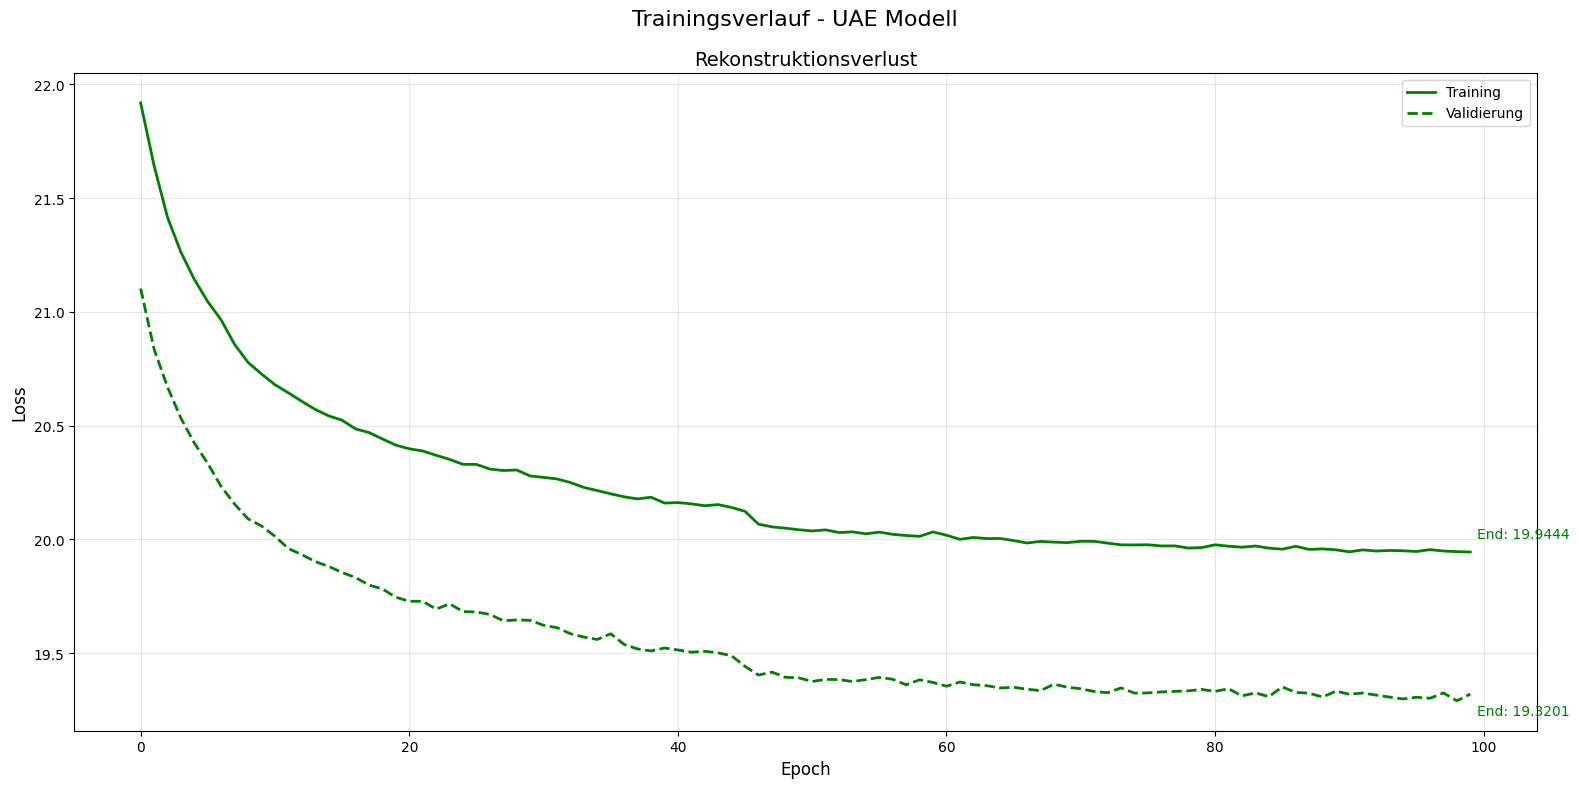

In [186]:
fig, axes = plot_loss_curves(
    history,
    model_type='uae',
    folder_name="ae_results"
)

## 3.Rekonstruktionsfehler berechnen

In [76]:
beste_threshold,_ = find_optimal_threshold(uae, X_test, y_test)
print(f"Optimaler Schwellenwert: {beste_threshold}")

Optimaler Schwellenwert (quantile 0.95): 1.4021873235702504
Optimaler Schwellenwert: 1.4021873235702504


In [77]:
display(beste_threshold)

1.4021873235702504

<ipython-input-74-84e77c3f6e1e>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/ae_results/reconstruction_analysis_20250302_105138.png


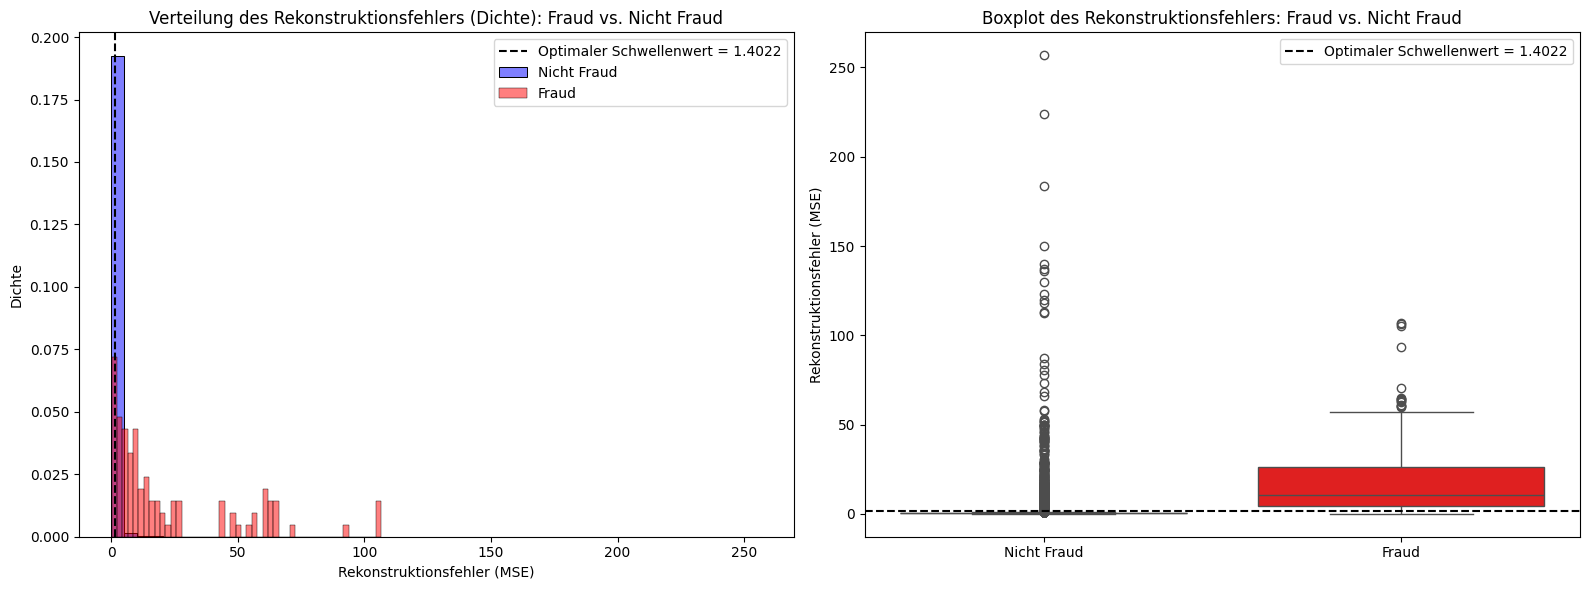

In [99]:
# Visualisierung und Speichern in Google Drive mit Markierung von Fraud vs. Nicht Fraud
plot_reconstruction_analysis(
    uae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="ae_results",
    threshold=beste_threshold  # Verwende den optimalen Schwellenwert
)

In [100]:
# Evaluieren der Fraud-Detektion, Metriken ausgeben und speichern
metrics = evaluate_fraud_detection(
    uae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    folder_name="ae_results",
    threshold=beste_threshold
)


Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.95      0.97     56864
       Fraud       0.03      0.88      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.91      0.52     56962
weighted avg       1.00      0.95      0.97     56962


Metriken:
Precision: 0.0302
Recall: 0.8776
F1-Score: 0.0583
Accuracy: 0.9512
ROC-AUC: 0.9145
Metriken wurden gespeichert unter: /content/drive/MyDrive/ae_results/metrics_20250302_105146.txt


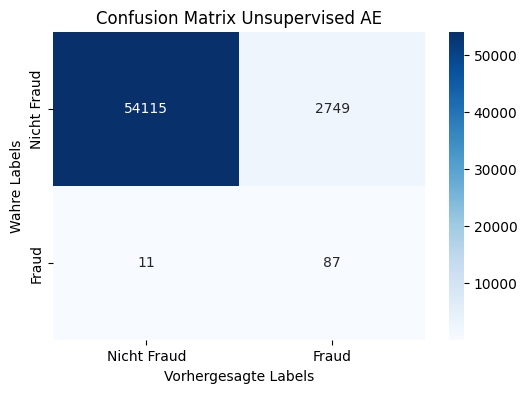

<Figure size 640x480 with 0 Axes>

In [101]:
fraud_predictions = detect_fraud(uae, X_test, beste_threshold
)
plot_confusion_matrix(model="Unsupervised AE", y_true=y_test, y_pred=fraud_predictions,folder_name="ae_results")

## 4.Plot AUC ROC /AUC PR Kurve

Optimaler Schwellenwert (quantile 0.95): 1.396175533533096
Optimaler Schwellenwert basierend auf F1-Score: 1.396175533533096
ROC-Kurve wurde gespeichert unter: /content/drive/MyDrive/ae_results/UnsupervisedAEroc_curve_20250302_105210.png
ROC-AUC: 0.9543


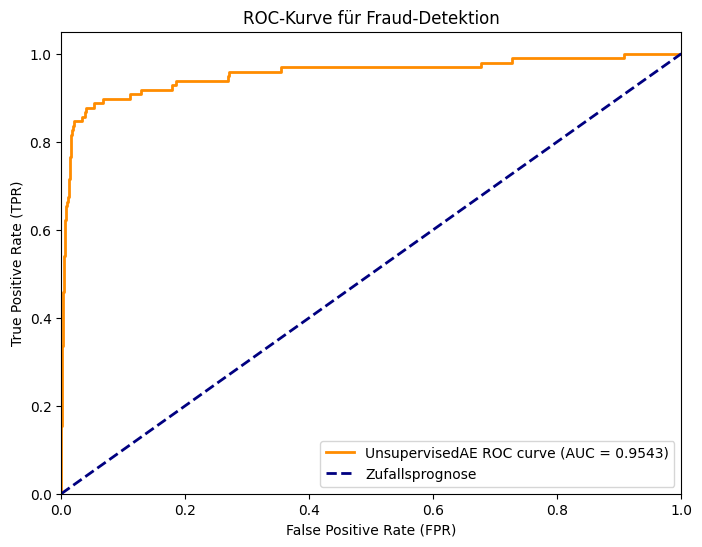

In [102]:
plot_roc_auc_curve(
    uae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="ae_results")

Precision-Recall-Kurve wurde gespeichert unter: /content/drive/MyDrive/ae_results/pr_curve_20250302_105216.png


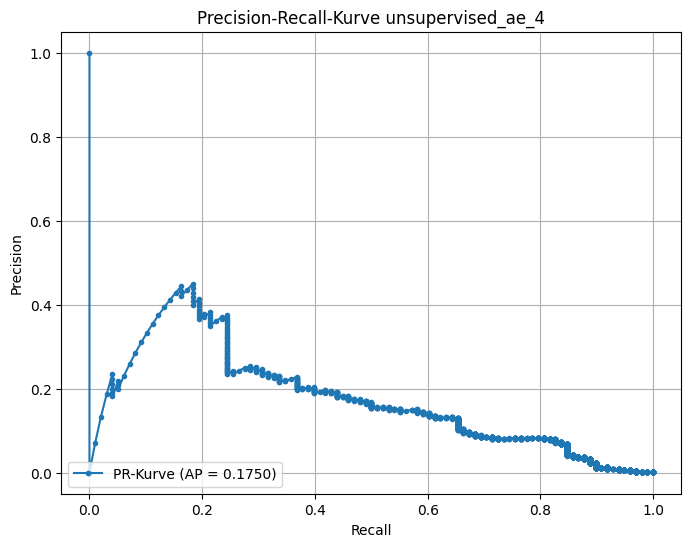

In [103]:
plot_pr_curve(
    uae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="ae_results")

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/ae_results/latent_space/latent_space_UnsupervisedAE_20250302_105224.png


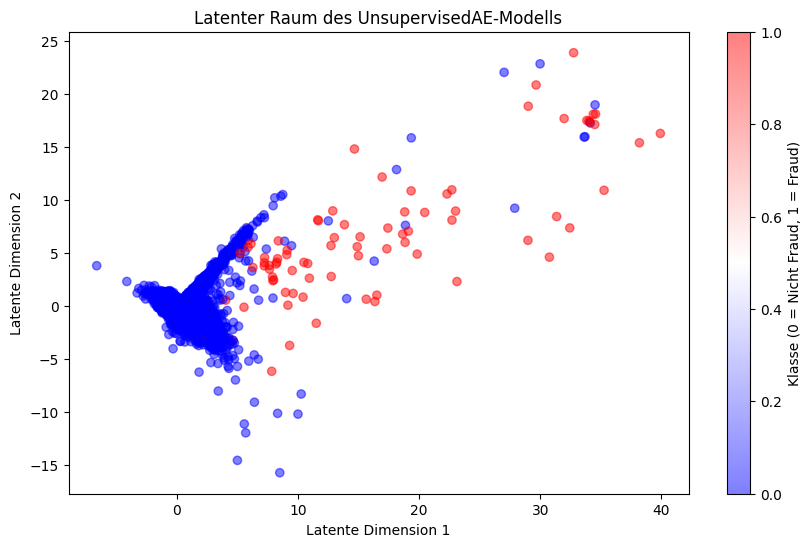

In [104]:
plot_latent_space(
    uae,
    X_test,
    np.squeeze(y_test),
    folder_name="ae_results/latent_space"
)

#II. Unsupervsied VAE  




---



## 1.VAE Klasse definieren

In [105]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from typing import List, Optional, Union, Tuple
@tf.keras.utils.register_keras_serializable()

class UnsupervisedVAE(Model):
    """
    Unüberwachter Variational Autoencoder für Anomalieerkennung.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        latent_dim (int): Dimension des latenten Raums (Standard: 16).
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
        kl_weight (float, optional): Gewichtungsfaktor für den KL-Verlust. Standardwert ist 1.0.
    """
    def __init__(
        self,
        input_dim: int,
        latent_dim: int = 16,
        hidden_dims: List[int] = [64, 32],
        activation: str = 'relu',
        dropout_rate: float = 0.0,
        kl_weight: float = 1.0,**kwargs
    ):
        super(UnsupervisedVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.activation = activation
        self.dropout_rate = dropout_rate

        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.kl_weight = kl_weight

        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

        class Sampling(layers.Layer):
            def call(self, inputs: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
                z_mean, z_log_var = inputs
                batch = tf.shape(z_mean)[0]
                dim = tf.shape(z_mean)[1]
                epsilon = tf.random.normal(shape=(batch, dim))
                return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        self.sampling = Sampling()

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='linear')

        # Metriken
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, x: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim).

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor]: (z_mean, z_log_var, z) – Mittelwert, Log-Varianz und gestochastische latente Variable.
        """
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim).

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim).
        """
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Vorwärtspass durch den VAE.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim).
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor]: (rekonstruiert, z_mean, z_log_var) – Rekonstruierte Daten, Mittelwert und Log-Varianz des latenten Raums.
        """
        z_mean, z_log_var, z = self.encode(inputs)
        reconstructed = self.decode(z)
        return reconstructed, z_mean, z_log_var

    def train_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Trainings-Schritt für den VAE mit MSE- und KL-Verlust.

        Args:
            data: Eingabetensor der Trainingsdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encode(x)
            reconstruction = self.decode(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
            total_loss = reconstruction_loss + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Test-Schritt für den VAE mit MSE- und KL-Verlust.

        Args:
            data: Eingabetensor der Testdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        z_mean, z_log_var, z = self.encode(x)
        reconstruction = self.decode(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
        total_loss = reconstruction_loss + self.kl_weight * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird
    def get_config(self):
        config = super(UnsupervisedVAE, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "hidden_dims": self.hidden_dims,
            "latent_dim": self.latent_dim,
            "activation": self.activation.__name__ if callable(self.activation) else self.activation,
            "dropout_rate": self.dropout_rate,
            "kl_weight": self.kl_weight,
        })
        # Falls "build_config" hinzugefügt wurde, kannst du ihn hier optional entfernen oder zurückgeben.
        # config["build_config"] = {"input_shape": [None, self.input_dim]}
        return config

    @classmethod
    def from_config(cls, config):
        # Entferne unerwünschte Schlüssel, bevor der Konstruktor aufgerufen wird
        config.pop("build_config", None)
        return cls(**config)


In [106]:
uvae = UnsupervisedVAE(
    input_dim=X_train_normal.shape[1],
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    activation=activation,
    dropout_rate=0.1,
    kl_weight=kl_weight
)

In [107]:
uvae.build(input_shape=(None, X_train.shape[1]))


## 2.Trainiern VAE unsupervised

In [109]:
uvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
history_uvae = uvae.fit(
    X_train_normal,
    epochs=epoch,
    batch_size=256,
    validation_split=0.1,
    verbose=0
)
# Ausgabe der Modellzusammenfassung
uvae.print_summary()

Model: "unsupervised_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (1, 64)                     │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (1, 16)                     │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (1, 16)                     │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling (Sampling)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (1, 32)                     │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (1, 64)                     │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (1, 30)                     │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,180 (113.99 KB)

 Trainable params: 9,726 (37.99 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,454 (76.00 KB)

In [127]:
# Modell speichern
save_dir = "/content/drive/MyDrive/models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
uvae.save(os.path.join(save_dir, "UVAE.keras"))


Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/vae_results/loss_curves_uvae_20250302_113857.png


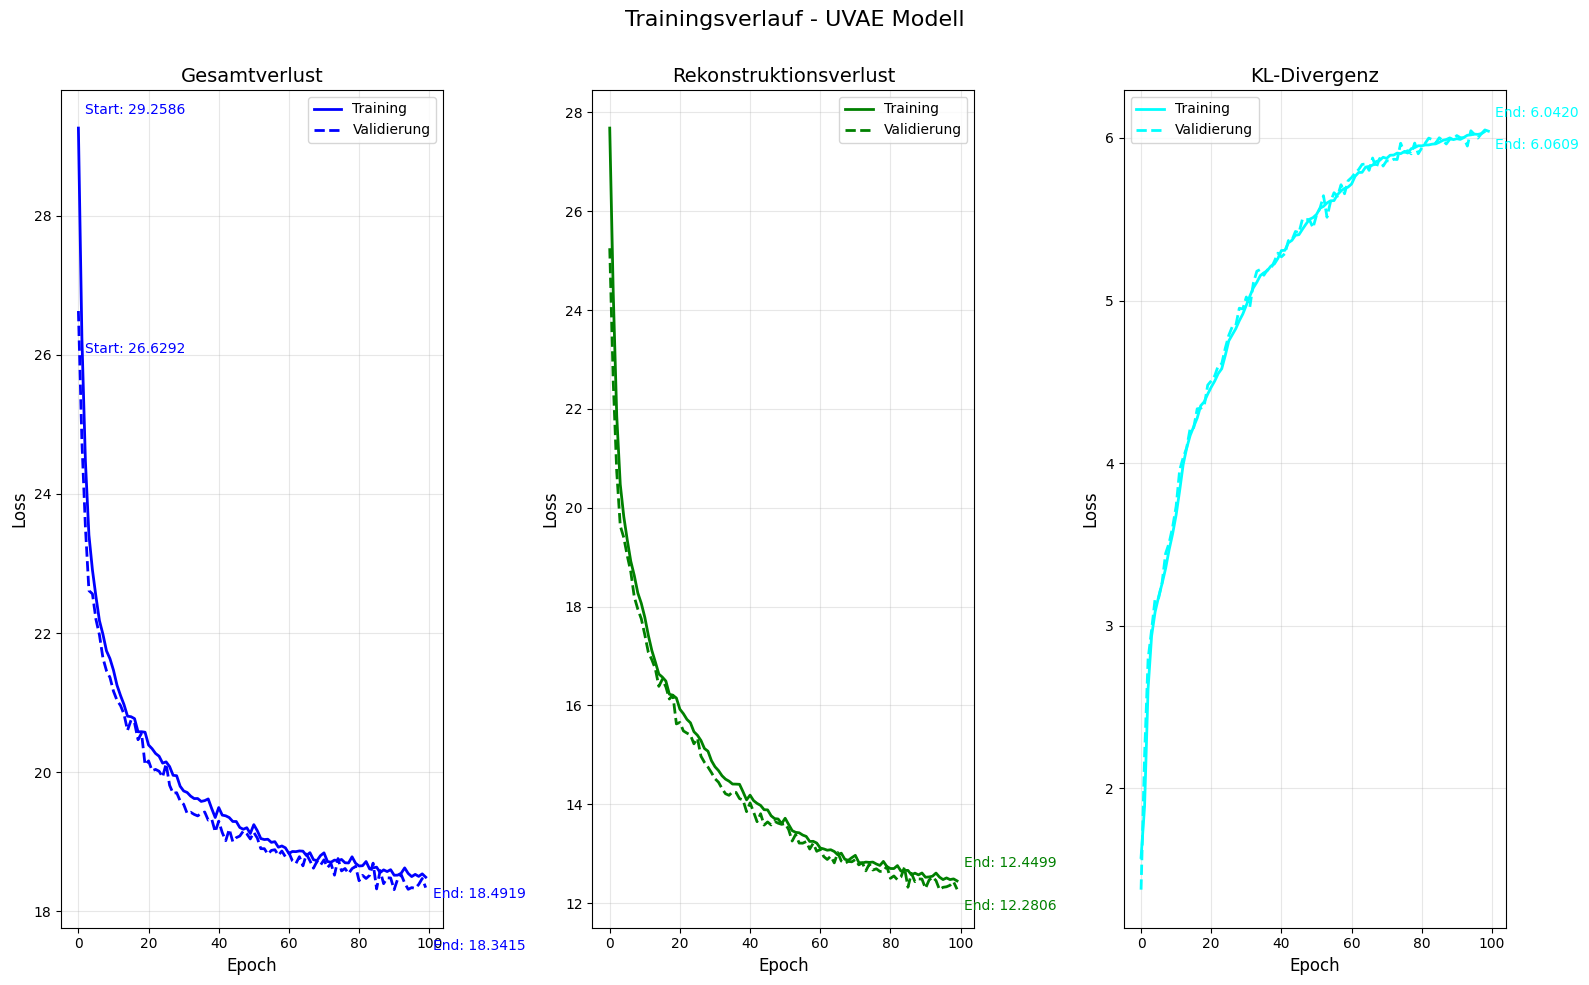

In [113]:
fig, axes = plot_loss_curves(history_uvae,model_type='uvae',folder_name="vae_results")

## 3.Rekonstruktiosnfehler berechnen

In [114]:
optimal_threshold_uvae, _ = find_optimal_threshold(uvae, X_test, y_test)
print(f"Optimaler Schwellenwert: {optimal_threshold_uvae}")

Optimaler Schwellenwert (quantile 0.95): 0.9488849043846121
Optimaler Schwellenwert: 0.9488849043846121


## 4.Visualisierung der Rekonstruktionsanalyse

<ipython-input-74-84e77c3f6e1e>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/vae_results/reconstruction_analysis_20250302_113941.png


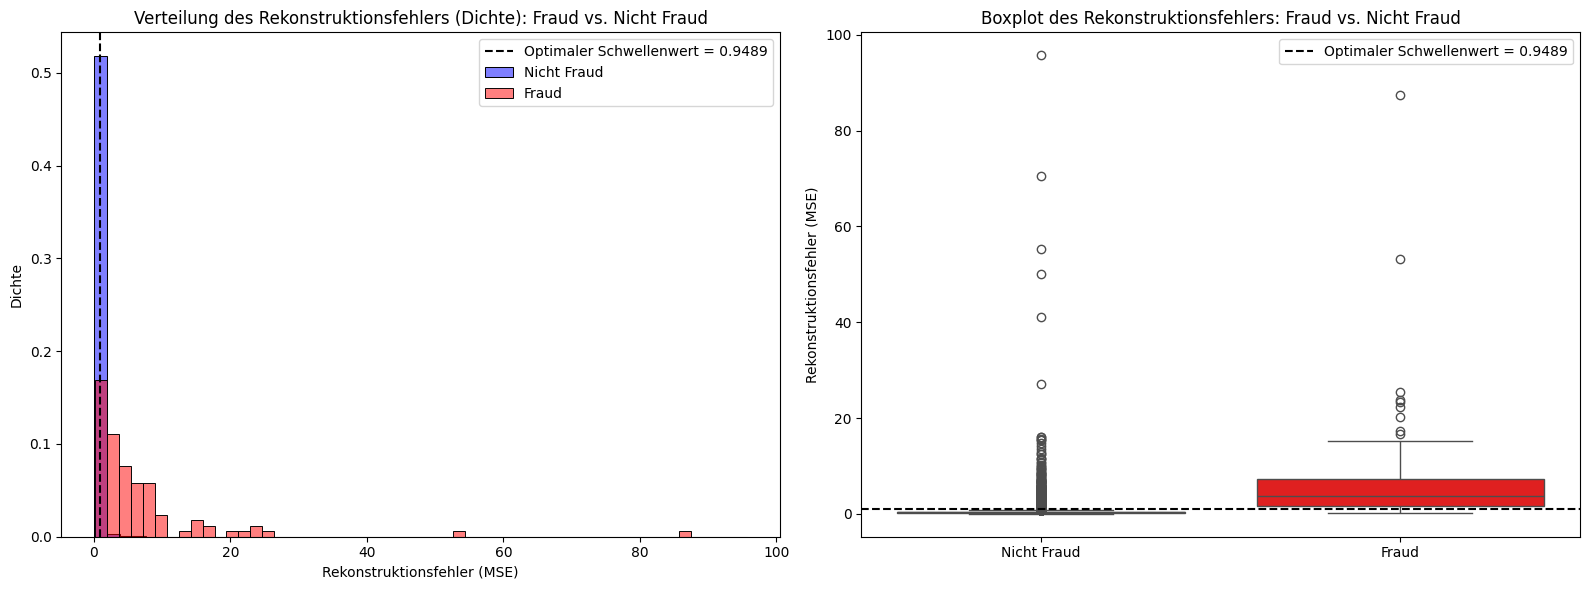

In [115]:
plot_reconstruction_analysis(
    uvae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    threshold=optimal_threshold_uvae,  # Verwende den optimalen Schwellenwert
    folder_name="vae_results"
    )

## 5.Visualisierung des Klassifikationsberichts

In [116]:
metrics_vae = evaluate_fraud_detection(
    uvae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    folder_name="vae_results",
    threshold=optimal_threshold_uvae
)


Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.95      0.98     56864
       Fraud       0.03      0.85      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962


Metriken:
Precision: 0.0297
Recall: 0.8469
F1-Score: 0.0574
Accuracy: 0.9522
ROC-AUC: 0.8996
Metriken wurden gespeichert unter: /content/drive/MyDrive/vae_results/metrics_20250302_114013.txt


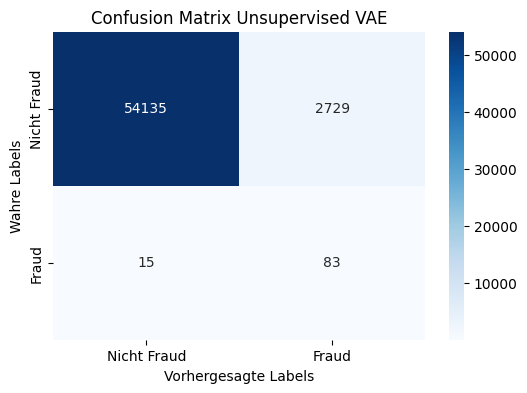

<Figure size 640x480 with 0 Axes>

In [117]:
fraud_predictions_uvae = detect_fraud(uvae, X_test,optimal_threshold_uvae)
plot_confusion_matrix(model="Unsupervised VAE", y_true=y_test, y_pred=fraud_predictions_uvae,folder_name="vae_results")

## 6.Plot AUC ROC /AUC PR Kurve

Optimaler Schwellenwert (quantile 0.95): 0.9447332024574279
Optimaler Schwellenwert basierend auf F1-Score: 0.9447332024574279
ROC-Kurve wurde gespeichert unter: /content/drive/MyDrive/vae_results/UnsupervisedVAEroc_curve_20250302_114046.png
ROC-AUC: 0.9398
Precision-Recall-Kurve wurde gespeichert unter: /content/drive/MyDrive/vae_results/pr_curve_20250302_114046.png


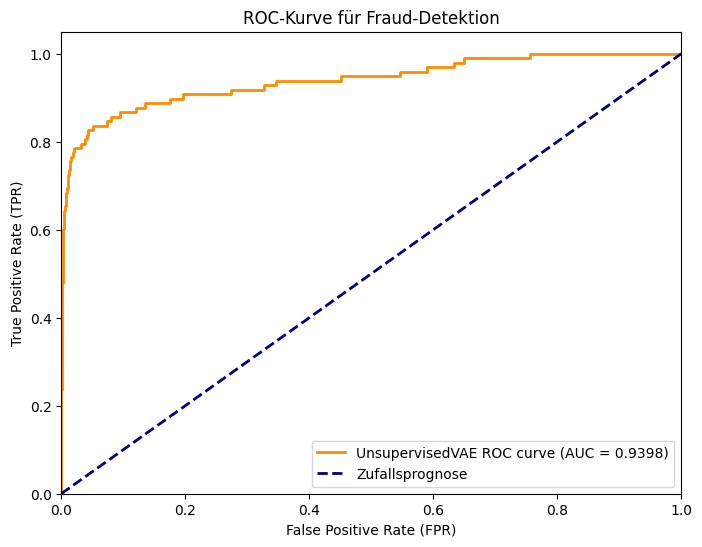

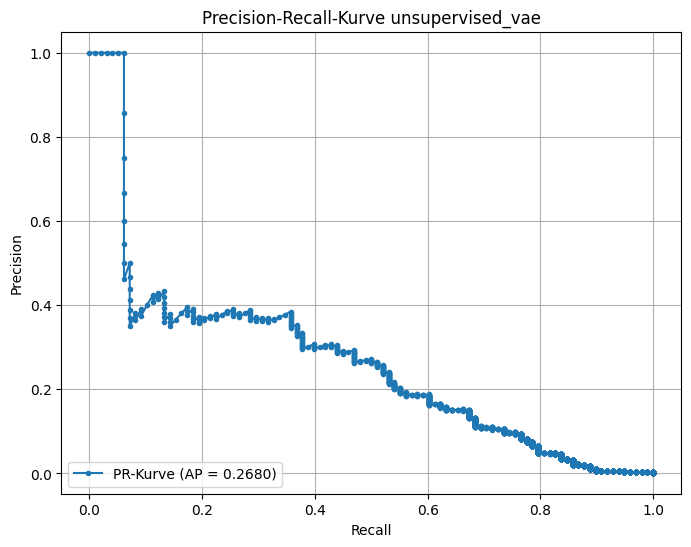

In [118]:
plot_roc_auc_curve(
    uvae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="vae_results")
plot_pr_curve(
    uvae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="vae_results")

## 7.Plot latent space

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/vae_results/latent_space_UnsupervisedVAE_20250302_114105.png


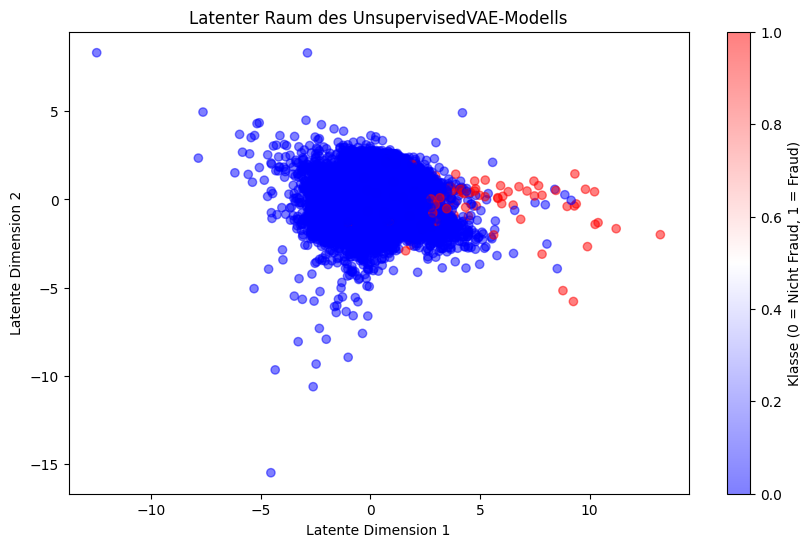

In [119]:
plot_latent_space(
    uvae,
    X_test,
    np.squeeze(y_test),
    folder_name="vae_results"
)

#III. Supervised AE

## 1.Klasse SAE definieren

In [175]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics, regularizers
from typing import List, Optional, Union, Tuple, Dict
@tf.keras.utils.register_keras_serializable()

class SupervisedAE(Model):
    """
    Überwachter Autoencoder für Anomalieerkennung mit Klassifikation und L2-Regularisierung für den Klassifikationsverlust.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        latent_dim (int): Dimension des latenten Raums (Standard: 32).
        classifier_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Klassifikator (Standard: [16, 8]).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
        l2_lambda (float, optional): L2-Regularisierungsfaktor für den Klassifikator (Standard: 0.01).
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 32,
        classifier_dims: List[int] = [16, 8],
        activation: str = 'relu',
        dropout_rate: float = 0.0,
        l2_lambda: float = 0.01  # L2-Regularisierungsfaktor für den Klassifikator
    ,**kwargs):
        super(SupervisedAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.activation = activation
        self.dropout_rate = dropout_rate

        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.kl_weight = kl_weight
        self.l2_lambda = l2_lambda


        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        # Latente Schicht im Encoder
        self.latent_layer = layers.Dense(latent_dim, activation=None, dtype=tf.float32)  # Keine Aktivierung für latenten Raum

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='linear', dtype=tf.float32)

        # Klassifikator-Schichten mit L2-Regularisierung und optionalem Dropout
        self.classifier_layers = [
            layers.Dense(dim, activation=self.activation, dtype=tf.float32)
            for dim in classifier_dims
        ]
        if dropout_rate > 0:
            self.classifier_dropout = layers.Dropout(dropout_rate)

        self.classifier_output = layers.Dense(1, activation='sigmoid', dtype=tf.float32)

        # Metriken
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss", dtype=tf.float32)
        self.classification_loss_tracker = metrics.Mean(name="classification_loss", dtype=tf.float32)
        self.total_loss_tracker = metrics.Mean(name="total_loss", dtype=tf.float32)

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [
            self.reconstruction_loss_tracker,
            self.classification_loss_tracker,
            self.total_loss_tracker
        ]

    def encode(self, x: tf.Tensor) -> tf.Tensor:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.

        Returns:
            Latenter Tensor der Form (Batch-Größe, latent_dim), als tf.float32.
        """
        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        return self.latent_layer(x)

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def classify(self, z: tf.Tensor) -> tf.Tensor:
        """
        Klassifikation der latenten Variablen in Betrugswahrscheinlichkeiten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Tensor der Form (Batch-Größe, 1) mit Wahrscheinlichkeiten (0-1), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        for layer in self.classifier_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.classifier_dropout(x, training=True)
        return self.classifier_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Vorwärtspass durch den SupervisedAE.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: (rekonstruiert, klassifiziert) – Rekonstruierte Daten und Klassifikationswahrscheinlichkeiten, beide als tf.float32.
        """
        if inputs.dtype != tf.float32:
            inputs = tf.cast(inputs, tf.float32)  # Konvertiere explizit zu float32
        encoded = self.encode(inputs)
        reconstructed = self.decode(encoded)
        classification = self.classify(encoded)
        return reconstructed, classification

    def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, tf.Tensor]:
        """
        Trainings-Schritt für den SupervisedAE mit MSE- und Binary Crossentropy-Verlust sowie L2-Regularisierung.

        Args:
            data: Tuple (x, y) mit Eingabedaten und Labels für TensorFlow 2.x, beide als tf.float32.

        Returns:
            Dictionary mit Metrikwerten.
        """
        x, y = data

        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)  # Konvertiere explizit zu float32

        # Formatiere y zu Shape (batch_size, 1), um mit der Klassifikationsausgabe übereinzustimmen
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)  # Füge eine Dimension hinzu: (batch_size,) -> (batch_size, 1)

        with tf.GradientTape() as tape:
            reconstructed, classification = self(x, training=True)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))
            classification_loss = tf.keras.losses.binary_crossentropy(y, classification)

            # Berechne Regularisierungsloss für den Klassifikator
            total_loss = self.l2_lambda*reconstruction_loss + tf.reduce_mean(classification_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

       # Aktualisiere die Metriken
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.total_loss_tracker.update_state(total_loss)

        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, tf.Tensor]:
        """
        Test-Schritt für den SupervisedAE mit MSE- und Binary Crossentropy-Verlust sowie L2-Regularisierung.

        Args:
            data: Tuple (x, y) mit Eingabedaten und Labels für TensorFlow 2.x, beide als tf.float32.

        Returns:
            Dictionary mit Metrikwerten.
        """
        x, y = data

        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)  # Konvertiere explizit zu float32

        # Formatiere y zu Shape (batch_size, 1), um mit der Klassifikationsausgabe übereinzustimmen
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)  # Füge eine Dimension hinzu: (batch_size,) -> (batch_size, 1)

        reconstructed, classification = self(x, training=False)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))
        classification_loss = tf.keras.losses.binary_crossentropy(y, classification)

        total_loss = self.l2_lambda *reconstruction_loss + tf.reduce_mean(classification_loss)

       # Aktualisiere die Metriken
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.total_loss_tracker.update_state(total_loss)

        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird

    def get_config(self):
        config = super(SupervisedAE, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "hidden_dims": self.hidden_dims,
            "latent_dim": self.latent_dim,
            "activation": self.activation.__name__ if callable(self.activation) else self.activation,
            "dropout_rate": self.dropout_rate,
            "kl_weight": self.kl_weight,
            "l2_lambda": self.l2_lambda,
        })
        # Falls "build_config" hinzugefügt wurde, kannst du ihn hier optional entfernen oder zurückgeben.
        # config["build_config"] = {"input_shape": [None, self.input_dim]}
        return config

    @classmethod
    def from_config(cls, config):
        # Entferne unerwünschte Schlüssel, bevor der Konstruktor aufgerufen wird
        config.pop("build_config", None)
        return cls(**config)


In [176]:
# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [177]:
# Konvertiere X und y zu float32 für TensorFlow
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

## 2.Trainieren des SupervisedAE

In [178]:
sae = SupervisedAE(
    input_dim=X_train.shape[1],
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    classifier_dims=classifier_dim,
    activation='mish',
    dropout_rate=0.1
)
sae.build(input_shape=(None, X_train.shape[1]))

sae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [179]:
history_sae = sae.fit(
    X_train, y_train,  # Tuple mit X_train und y_train
    epochs=epoch,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=0
)

In [181]:
# Modell speichern
save_dir = "/content/drive/MyDrive/models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
sae.save(os.path.join(save_dir, "SAE.keras"))


In [182]:
sae.print_summary()

Model: "supervised_ae_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)                    │ (1, 64)                     │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (1, 16)                     │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (1, 32)                     │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (1, 64)                     │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (1, 30)                     │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (1, 16)                     │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (1, 8)                      │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (1, 1)                      │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,847 (112.69 KB)

 Trainable params: 9,615 (37.56 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,232 (75.13 KB)

Plott alle Loss

Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/sae_results/loss_curves_sae.png


(<Figure size 1600x800 with 3 Axes>,
 array([<Axes: title={'center': 'Gesamtverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Rekonstruktionsverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Klassifikationsverlust'}, xlabel='Epoch', ylabel='Loss'>],
       dtype=object))

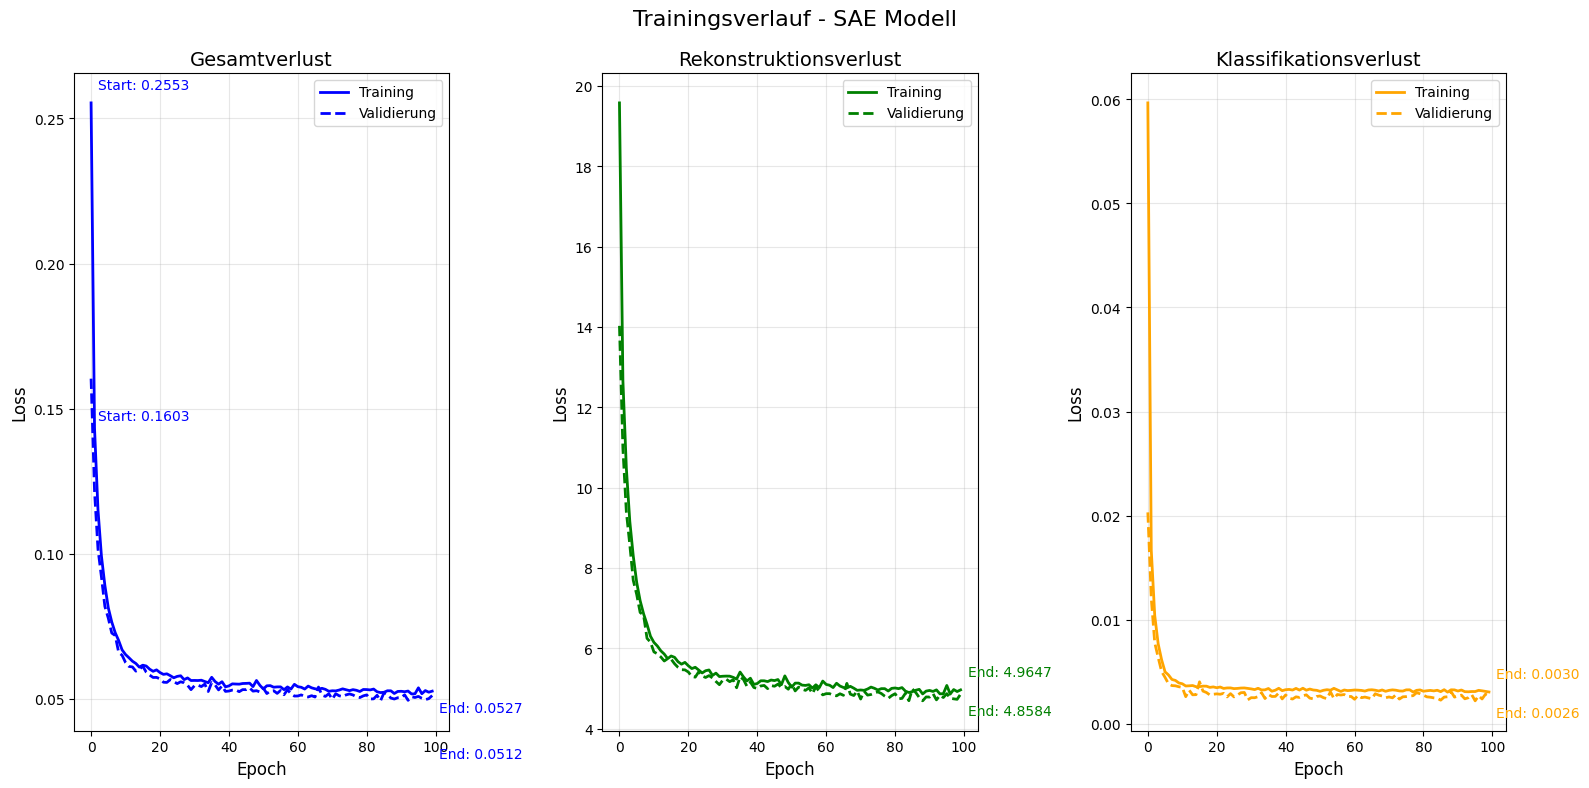

In [195]:
plot_loss_curves(history_sae,model_type='sae',folder_name="sae_results")

In [133]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score

## 3.Visualisierung der Rekonstruktionsanalyse

In [196]:
optimal_threshold_sae, _ = find_optimal_threshold(sae, X_test, y_test)
print(f"Optimaler Schwellenwert: {optimal_threshold_sae}")

Optimaler Schwellenwert (quantile 0.95): 0.46767001450061774
Optimaler Schwellenwert: 0.46767001450061774


<ipython-input-74-84e77c3f6e1e>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/sae_results/reconstruction_analysis_20250302_134636.png


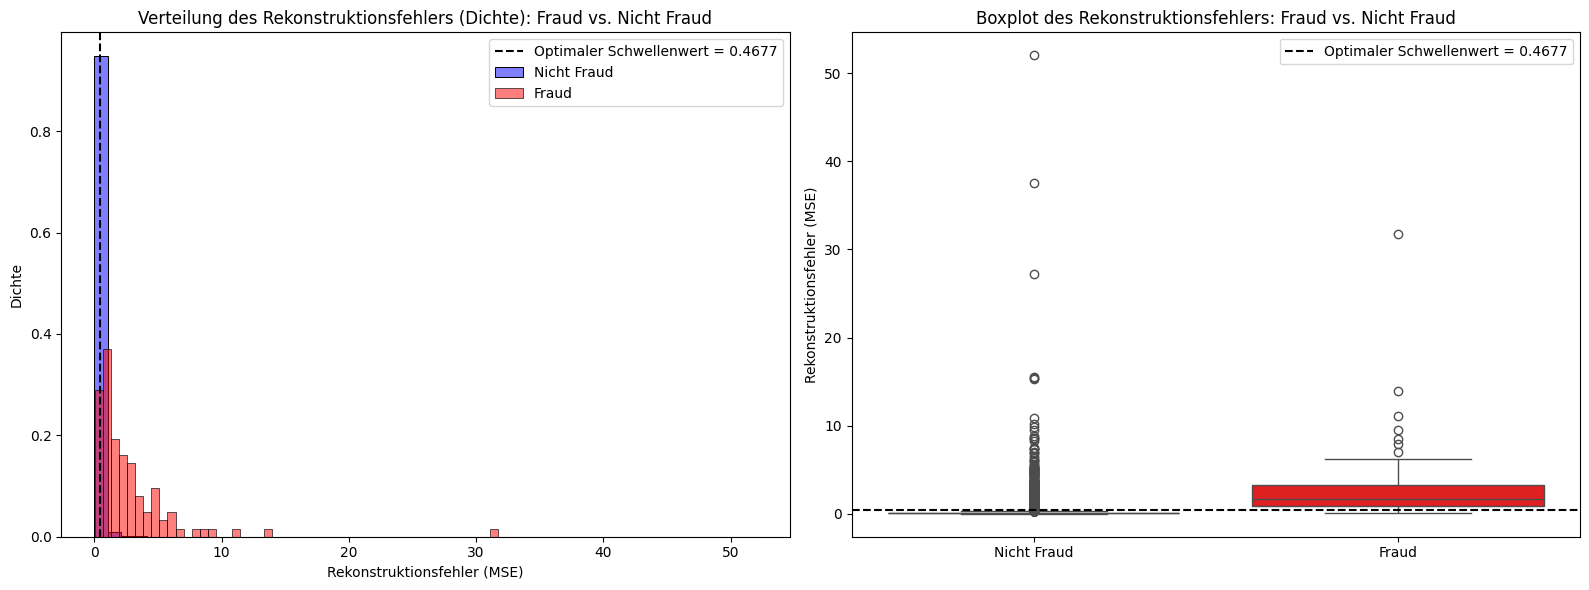

In [197]:
plot_reconstruction_analysis(
    sae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="sae_results",
    threshold=optimal_threshold_sae
    )

## 4.Plot AUC ROC

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Classification Performance:
Accuracy: 0.9993
Precision: 0.8554
Recall: 0.7245
F1 Score: 0.7845


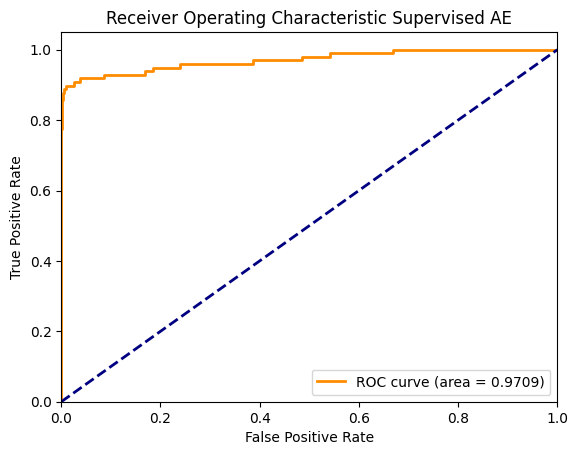

In [198]:
# Evaluate the classifier on test data
_, y_pred_prob_sae = sae.predict(X_test)
y_pred_sae = (y_pred_prob_sae > 0.5).astype(int)  # Apply threshold at 0.5

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_sae)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_sae, average='binary')

print(f"Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_sae)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Supervised AE')
plt.legend(loc="lower right")
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


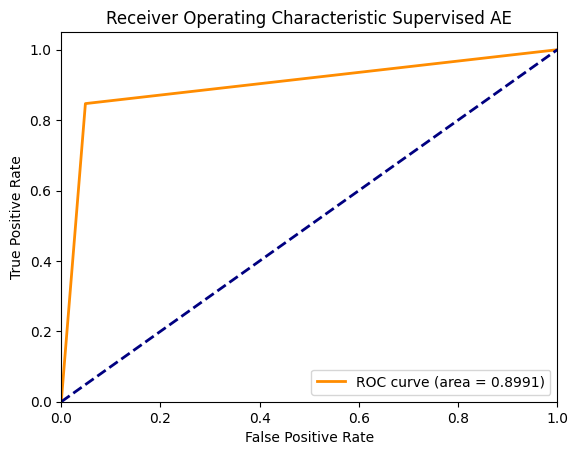

In [199]:
# Evaluate the classifier on test data
x_pred_prob_sae,_ = sae.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - x_pred_prob_sae), axis=1)
mse=np.quantile(reconstruction_error,0.95)

y_pred_sae_mse = (reconstruction_error > mse).astype(int)  # Apply threshold at 0.5

# ROC Curve
fpr, tpr, _ = roc_curve(y_test,y_pred_sae_mse)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Supervised AE')
plt.legend(loc="lower right")
plt.show()

## Clasifikation report nach Klassifkikationclass

In [200]:
classification_report_sae = classification_report(y_test, y_pred_sae)
print(classification_report_sae)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.86      0.72      0.78        98

    accuracy                           1.00     56962
   macro avg       0.93      0.86      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [201]:
classification_report_sae_mse = classification_report(y_test, y_pred_sae_mse)
print(classification_report_sae_mse)

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     56864
         1.0       0.03      0.85      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962



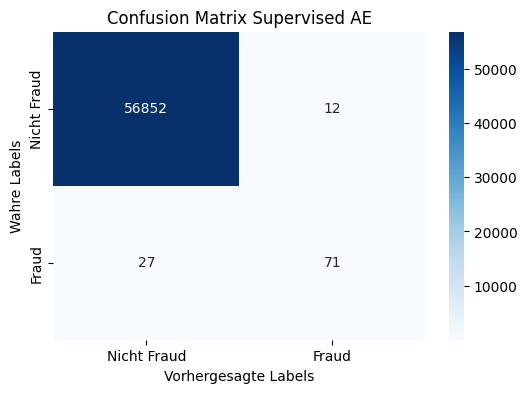

<Figure size 640x480 with 0 Axes>

In [206]:
plot_confusion_matrix(model="Supervised AE",y_true=y_test,y_pred=y_pred_sae,folder_name="sae_results")

## 5.Plot latent space

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/sae_results/latent_space_SupervisedAE_20250302_135208.png


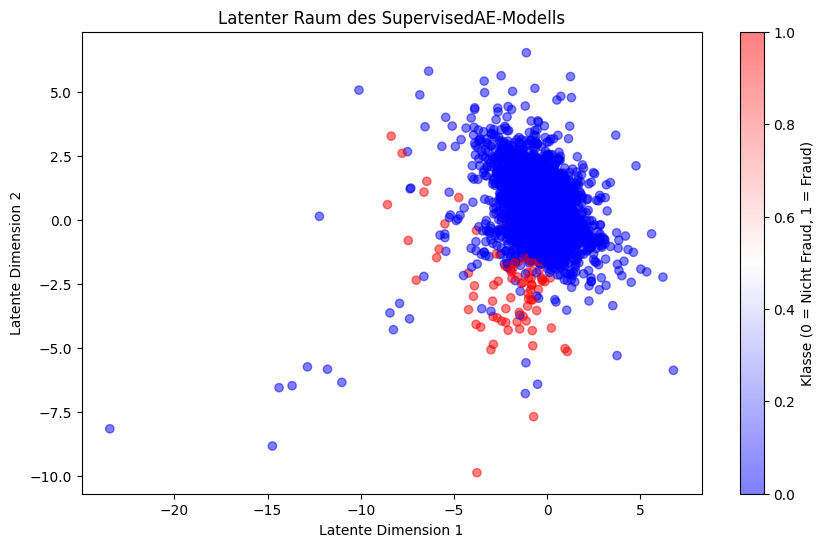

In [207]:
# Extract the latent representations
plot_latent_space(sae, X_test, y_test, folder_name="sae_results")

#IV. Supervised VAE

##1.Klasse SVAE def

In [208]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from typing import List, Optional, Union, Tuple, Dict
@tf.keras.utils.register_keras_serializable()

class SupervisedVAE(Model):
    """
    Überwachter Variational Autoencoder für Anomalieerkennung mit Klassifikation.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        latent_dim (int): Dimension des latenten Raums (Standard: 16).
        classifier_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Klassifikator (Standard: [16]).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
        kl_weight (float, optional): Gewichtungsfaktor für den KL-Verlust. Standardwert ist 1.0.
    """
    def __init__(
               self,
        input_dim: int,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 32,
        classifier_dims: List[int] = [16, 8],
        activation: str = 'relu',
        dropout_rate: float = 0.0,
        l2_lambda: float = 0.01,
        kl_weight: float = 1.0
    ,**kwargs):
        super(SupervisedVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.kl_weight = kl_weight
        self.l2_lambda = l2_lambda

        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        self.z_mean = layers.Dense(latent_dim, dtype=tf.float32)
        self.z_log_var = layers.Dense(latent_dim, dtype=tf.float32)

        class Sampling(layers.Layer):
            def call(self, inputs: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
                z_mean, z_log_var = inputs
                batch = tf.shape(z_mean)[0]
                dim = tf.shape(z_mean)[1]
                epsilon = tf.random.normal(shape=(batch, dim), dtype=tf.float32)
                return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        self.sampling = Sampling()

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='linear', dtype=tf.float32)

         # Klassifikator-Schichten und optionalem Dropout
        self.classifier_layers = [
            layers.Dense(dim, activation=self.activation, dtype=tf.float32)
            for dim in classifier_dims
        ]
        if dropout_rate > 0:
            self.classifier_dropout = layers.Dropout(dropout_rate)
        self.classifier_output = layers.Dense(1, activation='sigmoid', dtype=tf.float32)

        # Metriken
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss", dtype=tf.float32)
        self.classification_loss_tracker = metrics.Mean(name="classification_loss", dtype=tf.float32)
        self.kl_loss_tracker = metrics.Mean(name="kl_loss", dtype=tf.float32)
        self.total_loss_tracker = metrics.Mean(name="total_loss", dtype=tf.float32)

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [
            self.reconstruction_loss_tracker,
            self.classification_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def encode(self, x: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor]: (z_mean, z_log_var, z) – Mittelwert, Log-Varianz und gestochastische latente Variable, alle als tf.float32.
        """
        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def classify(self, z: tf.Tensor) -> tf.Tensor:
        """
        Klassifikation der latenten Variablen in Betrugswahrscheinlichkeiten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Tensor der Form (Batch-Größe, 1) mit Wahrscheinlichkeiten (0-1), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        for layer in self.classifier_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.classifier_dropout(x, training=True)
        return self.classifier_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Vorwärtspass durch den SupervisedVAE.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]: (rekonstruiert, z_mean, z_log_var, klassifiziert) – Rekonstruierte Daten, Mittelwert, Log-Varianz des latenten Raums und Klassifikationswahrscheinlichkeiten, alle als tf.float32.
        """
        if inputs.dtype != tf.float32:
            inputs = tf.cast(inputs, tf.float32)  # Konvertiere explizit zu float32
        z_mean, z_log_var, z = self.encode(inputs)
        reconstructed = self.decode(z)
        classification = self.classify(z_mean)  # Verwende z_mean für Klassifikation
        return reconstructed, z_mean, z_log_var, classification

    def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
        """
        Trainings-Schritt für den SupervisedVAE mit MSE-, Binary Crossentropy- und KL-Verlust.
        """
        # Debugging und Datenextraktion (wie zuvor)
        x, y = data
        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)

        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var, classification = self.call(x, training=True)

            # Rekonstruktionsverlust (MSE)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))

            # Klassifikationsverlust (Binary Crossentropy)
            classification_loss = tf.keras.losses.binary_crossentropy(y, classification)

            # KL-Verlust
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))

            # Gesamtverlust
            total_loss = self.l2_lambda*reconstruction_loss + tf.reduce_mean(classification_loss) + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Aktualisiere Metriken, einschließlich 'loss'
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)  # Speichere 'loss' als total_loss

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
        """
        Test-Schritt für den SupervisedVAE mit MSE-, Binary Crossentropy- und KL-Verlust.

        Args:
            data: Tuple (x, y) mit Eingabedaten und Labels für TensorFlow 2.18, beide als tf.float32.

        Returns:
            Dictionary mit Metrikwerten.
        """
        x, y = data

        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)  # Konvertiere explizit zu float32

        # Formatiere y zu Shape (batch_size, 1), um mit der Klassifikationsausgabe übereinzustimmen
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)  # Füge eine Dimension hinzu: (batch_size,) -> (batch_size, 1)

        reconstructed, z_mean, z_log_var, classification = self.call(x, training=False)

        # Rekonstruktionsverlust (MSE)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))

        # Klassifikationsverlust (Binary Crossentropy)
        classification_loss = tf.keras.losses.binary_crossentropy(y, classification)

        # KL-Verlust
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))

        # Gesamtverlust
        total_loss = reconstruction_loss + tf.reduce_mean(classification_loss) + self.kl_weight * kl_loss

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)  # Speichere 'loss' als total_loss

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird

    def get_config(self):
        config = super(SupervisedAE, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "hidden_dims": self.hidden_dims,
            "latent_dim": self.latent_dim,
            "activation": self.activation.__name__ if callable(self.activation) else self.activation,
            "dropout_rate": self.dropout_rate,
            "kl_weight": self.kl_weight,
            "l2_lambda": self.l2_lambda,
        })
        # Falls "build_config" hinzugefügt wurde, kannst du ihn hier optional entfernen oder zurückgeben.
        # config["build_config"] = {"input_shape": [None, self.input_dim]}
        return config

    @classmethod
    def from_config(cls, config):
        # Entferne unerwünschte Schlüssel, bevor der Konstruktor aufgerufen wird
        config.pop("build_config", None)
        return cls(**config)



In [149]:
# Konvertiere X und y zu float32 für TensorFlow und forme y zu (batch_size, 1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = np.expand_dims(y_train.astype(np.float32), axis=-1)  # Shape (n_samples, 1)
y_test = np.expand_dims(y_test.astype(np.float32), axis=-1)    # Shape (n_samples, 1)

# Debugging-Ausgabe, um die Formate zu überprüfen
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train unique values:", np.unique(y_train))
print("y_train dtype:", y_train.dtype)
print("X_train dtype:", X_train.dtype)

X_train shape: (227845, 30)
y_train shape: (227845, 1)
y_train unique values: [0. 1.]
y_train dtype: float32
X_train dtype: float32


## 2.Trainieren

In [209]:
svae = SupervisedVAE(
    input_dim=X_train.shape[1],
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    classifier_dims=classifier_dim,
    activation=activation,
    dropout_rate=dropout_rate,
    kl_weight=kl_weight
)
sae.build(input_shape=(None, X_train.shape[1]))

svae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [210]:
history_svae = svae.fit(
    X_train, y_train,  # Tuple mit X_train und y_train
    epochs=epoch,
    validation_split=0.1,
    verbose=0
)

In [ ]:
# Modell speichern
save_dir = "/content/drive/MyDrive/models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
sae.save(os.path.join(save_dir, "SAE.keras"))

In [212]:
# Ausgabe der Modellzusammenfassung
svae.print_summary()

Model: "supervised_vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)                    │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling_2 (Sampling)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,431 (118.88 KB)

 Trainable params: 10,143 (39.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,288 (79.25 KB)

In [213]:
# Bestimmen des optimalen Schwellenwerts
optimal_threshold, _ = find_optimal_threshold(svae, X_test, np.squeeze(y_test))  # Squeeze y_test, um (n_samples,) zu erhalten
print(f"Optimaler Schwellenwert basierend auf F1-Score: {optimal_threshold}")


Optimaler Schwellenwert (quantile 0.95): 1.9627891182899422
Optimaler Schwellenwert basierend auf F1-Score: 1.9627891182899422


## 3.Visualisireung der Rekonstruktionsanalyse

Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/svae_results/loss_curves/loss_curves_svae.png


(<Figure size 1600x800 with 4 Axes>,
 array([<Axes: title={'center': 'Gesamtverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Rekonstruktionsverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'KL-Divergenz'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Klassifikationsverlust'}, xlabel='Epoch', ylabel='Loss'>],
       dtype=object))

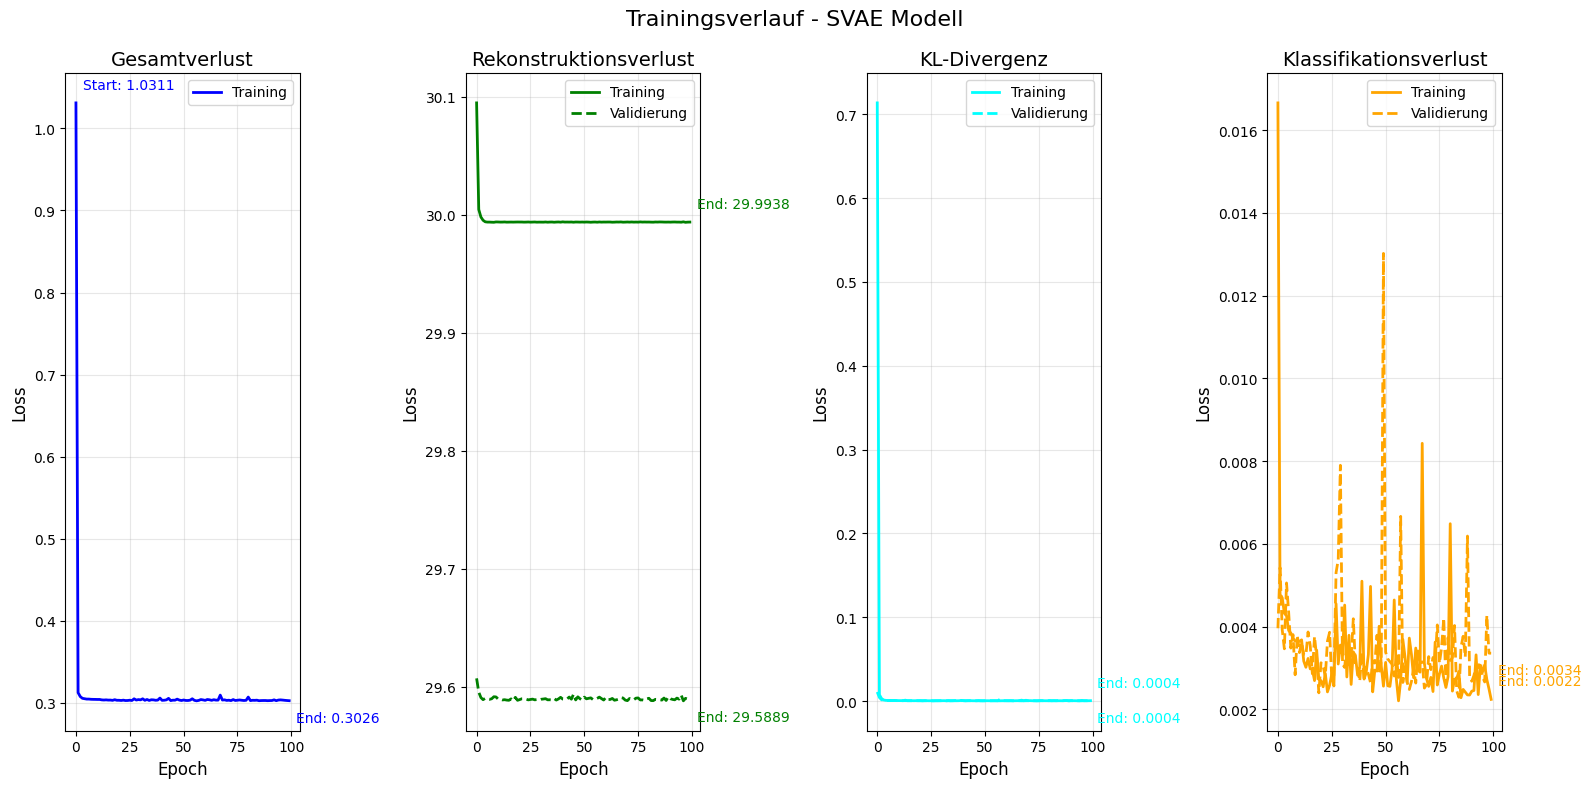

In [214]:
plot_loss_curves(history_svae,model_type="svae", folder_name="svae_results/loss_curves")

<ipython-input-74-84e77c3f6e1e>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/svae_results/reconstruction_analysis/reconstruction_analysis_20250302_143707.png


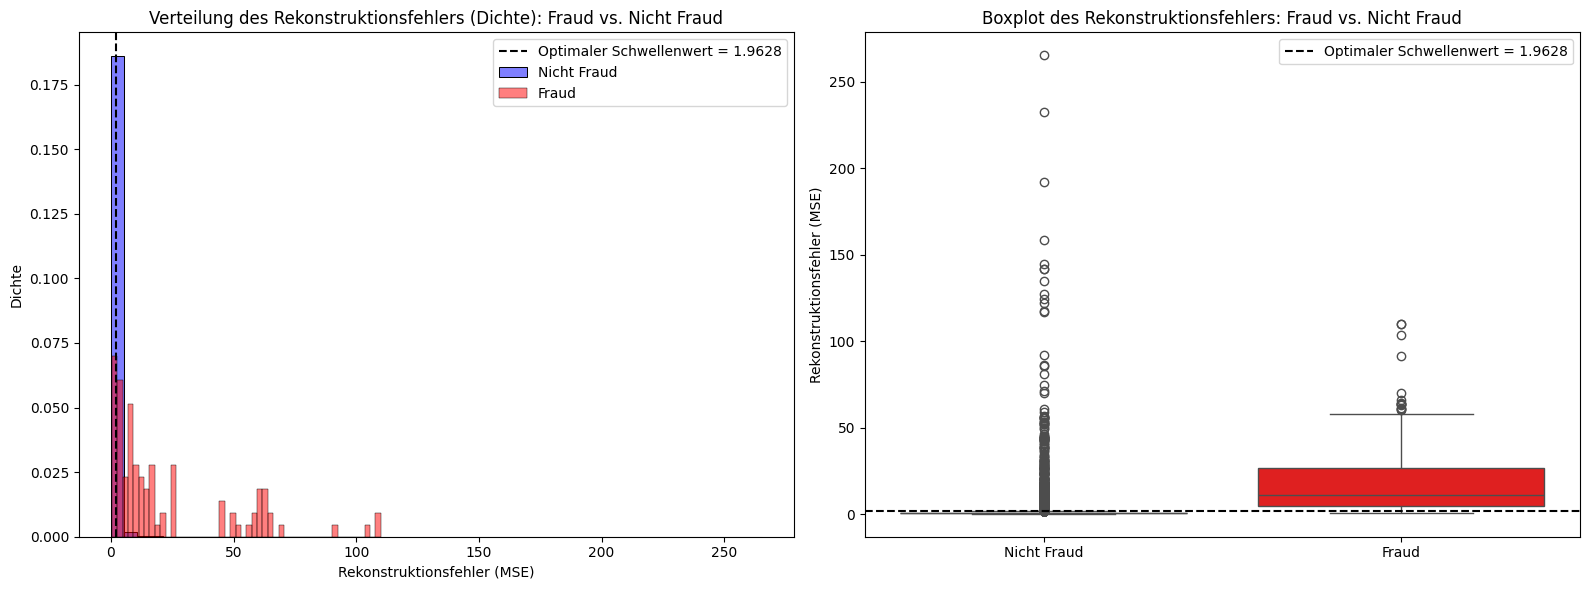

In [216]:
plot_reconstruction_analysis(
    svae,
    X_test,
    np.squeeze(y_test),  # Squeeze y_test, um (n_samples,) zu erhalten
    threshold=optimal_threshold,
    folder_name="svae_results/reconstruction_analysis"
)

##4. Plot AUC ROC

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Classification Performance:
Accuracy: 0.9994
Precision: 0.8706
Recall: 0.7551
F1 Score: 0.8087


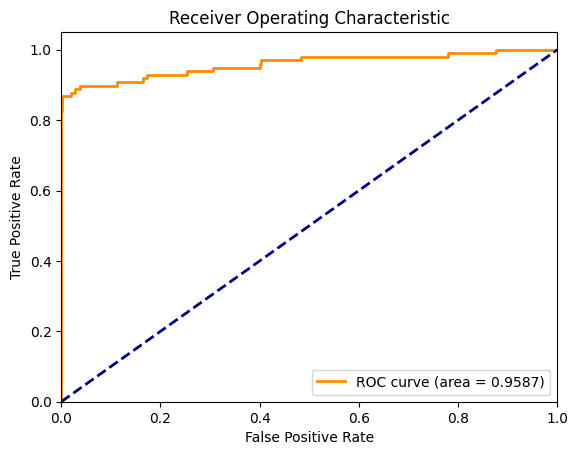

In [217]:
# Evaluate the classifier on test data
_,_,_, y_pred_prob_svae = svae.predict(X_test)
y_pred_svae = (y_pred_prob_svae > 0.5).astype(int)  # Apply threshold at 0.5

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svae)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svae, average='binary')

print(f"Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_svae)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Classifikation report

In [218]:
classification_report_svae = classification_report(y_test, y_pred_svae)
print(classification_report_svae)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.87      0.76      0.81        98

    accuracy                           1.00     56962
   macro avg       0.94      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962



## 5.Plotten des latenten Raums

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/svae_results/latent_space/latent_space_SupervisedVAE_20250302_143757.png


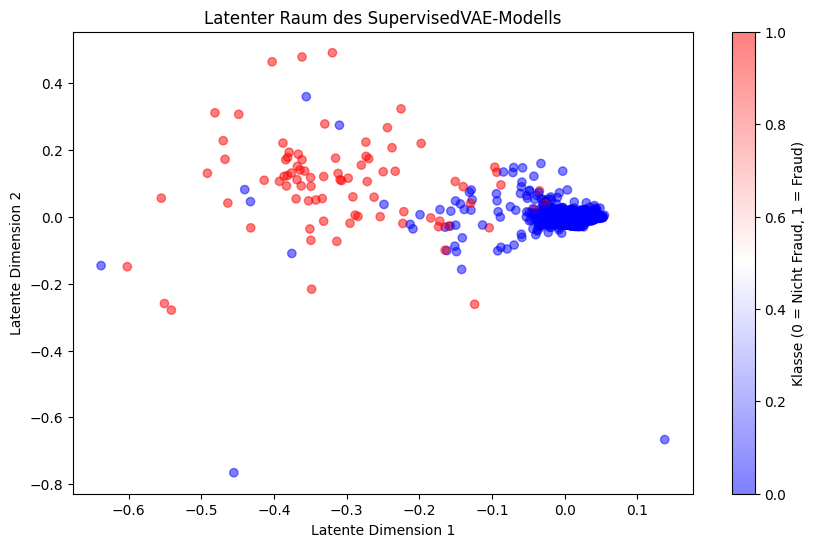

In [219]:
plot_latent_space(
    svae,
    X_test,
    np.squeeze(y_test),  # Squeeze y_test, um (n_samples,) zu erhalten
    folder_name="svae_results/latent_space"
)

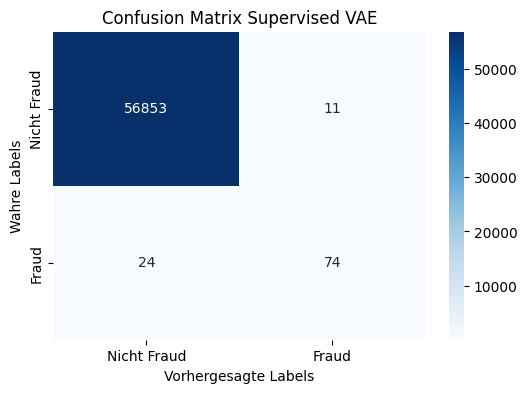

<Figure size 640x480 with 0 Axes>

In [220]:
plot_confusion_matrix(model="Supervised VAE",y_true=y_test,y_pred=y_pred_svae,folder_name="sae_results")

_______________________________________________________

---



In [221]:
# Modellinstanziierung
models = {
    'UnsupervisedAE': UnsupervisedAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=32,
        activation='mish',
        dropout_rate=0.1
    ),
    'UnsupervisedVAE': UnsupervisedVAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=16,
        activation='mish',
        dropout_rate=0.1,
        kl_weight=1.0
    ),
    'SupervisedAE': SupervisedAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=32,
        classifier_dims=[16],
        activation='mish',
        dropout_rate=0.1
    ),
    'SupervisedVAE': SupervisedVAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=16,
        classifier_dims=[16],
        activation='mish',
        dropout_rate=0.1,
        kl_weight=1.0
    )
}

In [222]:
def train_and_plot_model(model_class, model_type, X_train, y_train, X_test, y_test):
    learning_rate = 0.001  # Definieren Sie den Lernrate-Wert
    if model_type in ['uae', 'uvae']:
        # Für unüberwachte Modelle: Nur normale Daten (Class=0) verwenden
        X_train_normal = X_train[y_train.flatten() == 0]
        model = model_class(
            input_dim=X_train.shape[1],
            latent_dim=16,
            hidden_dims=[64, 32],
            activation='mish',
            dropout_rate=0.1
        )
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        history = model.fit(X_train_normal, epochs=5, batch_size=256,validation_split=0.1, verbose=0)
    else:  # 'sae', 'svae'
        model = model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=16,
            classifier_dims=[16],
            activation='mish',
            dropout_rate=0.1
        )
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        history = model.fit(X_train,y_train, epochs=5, validation_split=0.1, verbose=0)

    # Plotten der Loss-Kurven
    fig, axes = plot_loss_curves(
        history,
        model_type=model_type,
        folder_name="all_results/loss_curves"
    )
    #model.save_model_to_drive()



In [ ]:
# Trainieren und plotten für jedes Modell
for model_class, model_type in [
    (UnsupervisedAE, 'uae'),
    (UnsupervisedVAE, 'uvae'),
    (SupervisedAE, 'sae'),
    (SupervisedVAE, 'svae')
]:
    print(f"\nTraining und Plotten für {model_type.upper()}...")
    train_and_plot_model(model_class, model_type, X_train, y_train, X_test, y_test)


Training und Plotten für UAE...
Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_uae_20250301_093813.png

Training und Plotten für UVAE...
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_uvae_20250301_093857.png

Training und Plotten für SAE...
Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_sae_20250301_094229.png

Training und Plotten für SVAE...
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_svae_20250301_094501.png


# VI. Hyperparameter-Tuining

In [223]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.0 MB/s eta 0:00:00


In [224]:
import optuna
from sklearn.model_selection import StratifiedKFold

## Hilffunktion um Modell zu erstellen

In [229]:
def create_model(model_class, latent_dim, activation, dropout_rate, kl_weight=None, classifier_dims=None):
    if model_class in [UnsupervisedVAE, SupervisedVAE]:
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            activation=activation,
            dropout_rate=dropout_rate,
            kl_weight=kl_weight if kl_weight is not None else 1.0
        )
    elif model_class == SupervisedAE:
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            classifier_dims=classifier_dims,  # Einzelne Schicht für SAE
            activation=activation,
            dropout_rate=dropout_rate
        )
    else:  # UnsupervisedAE
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            activation=activation,
            dropout_rate=dropout_rate
        )

## Optuna-Studien für jedes Modell


In [225]:
# StratifiedKFold für Kreuzvalidierung (5 Folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Daten vorbereitet. Shapes:", X_train.shape, y_train.shape)

Daten vorbereitet. Shapes: (227845, 30) (227845,)


In [226]:
# Dictionary zur Speicherung der besten Parameter
best_params_dict = {}

In [227]:
import json # Import the json module
from sklearn.model_selection import StratifiedKFold

In [231]:
# Dictionary zur Speicherung der besten Parameter
best_params_dict = {}

# Optimierung nur für UnsupervisedAE
model_class = UnsupervisedAE
model_type = 'uae'
model_name = model_class.__name__
print(f"\nStarte Hyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

# Erstelle eine Optuna-Studie
study_uae = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
def objective_ae(trial):
    # Hyperparameter-Suchraum
    latent_dim = trial.suggest_categorical('latent_dim', [2, 8, 16])
    activation = trial.suggest_categorical('activation', ['relu', 'mish',"swish"])
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)

    # Initialisiere ROC-AUC über die Folds
    roc_auc_scores = []

    # StratifiedKFold für robuste Evaluierung
    for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Erstelle und kompiliere das Modell
        model = create_model(model_class,latent_dim, activation, dropout_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        # Baue das Modell
        X_train_normal_fold = X_train_fold[y_train_fold.flatten() == 0]
        if len(X_train_normal_fold) == 0:
            raise ValueError("Keine normalen Daten gefunden!")
        model.build(input_shape=(None, X_train_normal_fold.shape[1]))
        history = model.fit(X_train_normal_fold, epochs=30, batch_size=64, validation_data=(X_val_fold[y_val_fold.flatten() == 0], None), verbose=0)

        # Berechne Rekonstruktionsfehler für Validierungsdaten
        recon_error = calculate_reconstruction_error(model, X_val_fold)
        if np.any(np.isnan(recon_error)):
            recon_error = np.nan_to_num(recon_error, nan=np.mean(recon_error))
        roc_auc = roc_auc_score(y_val_fold.flatten(), recon_error)

        roc_auc_scores.append(roc_auc)

    # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
    mean_roc_auc = np.mean(roc_auc_scores)
    return mean_roc_auc


# Führe 20 Trials durch
study_uae.optimize(objective_ae, n_trials=10)

# Speichere die besten Parameter
best_params = study_uae.best_params
best_params_dict[model_name] = best_params
print(f"Beste Parameter für {model_name}: {best_params}")
print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study_uae.best_value:.4f}")

[I 2025-03-02 14:49:31,314] A new study created in memory with name: no-name-f75075bd-2434-4825-9080-b46a2c2498fe



Starte Hyperparameter-Optimierung mit Optuna für UnsupervisedAE (ROC-AUC mit StratifiedKFold)...


[I 2025-03-02 15:06:59,281] Trial 0 finished with value: 0.9524700357378257 and parameters: {'latent_dim': 2, 'activation': 'relu', 'learning_rate': 0.00025433359932671855, 'dropout_rate': 0.15101333477018927}. Best is trial 0 with value: 0.9524700357378257.
[I 2025-03-02 15:24:32,424] Trial 1 finished with value: 0.9510421405704734 and parameters: {'latent_dim': 16, 'activation': 'swish', 'learning_rate': 0.0006178651147669144, 'dropout_rate': 0.018465210869994374}. Best is trial 0 with value: 0.9524700357378257.
[W 2025-03-02 15:37:18,993] Trial 2 failed with parameters: {'latent_dim': 16, 'activation': 'relu', 'learning_rate': 0.0011831488317109575, 'dropout_rate': 0.1800942939137986} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-231-af4b5143aa15>", line

KeyboardInterrupt: 

<ipython-input-58-f7ad013fdfa5>:5: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

<ipython-input-58-f7ad013fdfa5>:6: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



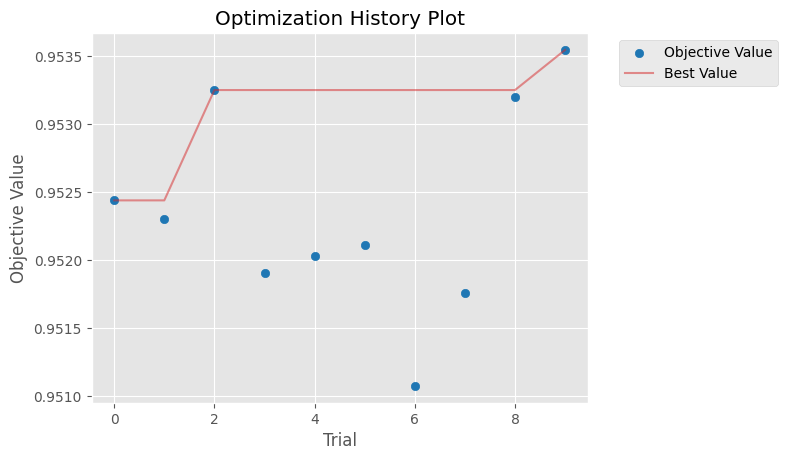

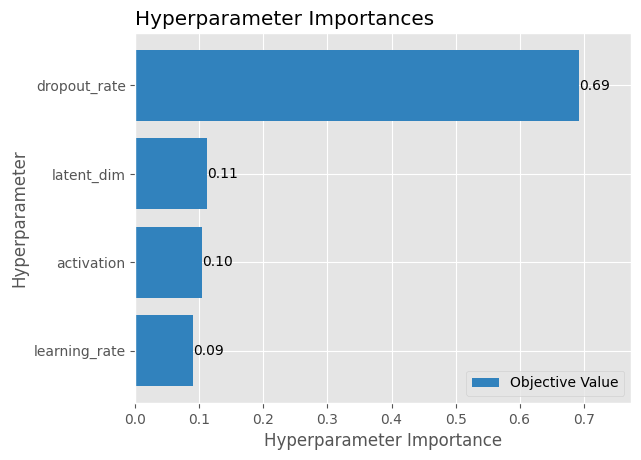

In [ ]:
import matplotlib.pyplot as plt

# UAE
axes[0, 0].set_title('UAE Hyperparameter Optimization')
optuna.visualization.matplotlib.plot_optimization_history(study_uae)
optuna.visualization.matplotlib.plot_param_importances(study_uae)
fig.show()

## Optuna VAE

In [ ]:
# Dictionary zur Speicherung der besten Parameter
# Optimierung nur für UnsupervisedAE
model_class = UnsupervisedVAE
model_type = 'uvae'
model_name = model_class.__name__
print(f"\nStarte Hyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

# Erstelle eine Optuna-Studie
study_uvae = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
def objective_uvae(trial):
    # Hyperparameter-Suchraum
    latent_dim = trial.suggest_categorical('latent_dim', [2, 8, 16])
    activation = trial.suggest_categorical('activation', ['relu', 'mish',"swish"])
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)
    kl_weight = trial.suggest_float('kl_weight', 0.5, 2.0)
    # Initialisiere ROC-AUC über die Folds
    roc_auc_scores = []

    # StratifiedKFold für robuste Evaluierung
    for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Erstelle und kompiliere das Modell
        model = create_model(model_class,latent_dim, activation, dropout_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        # Baue das Modell
        X_train_normal_fold = X_train_fold[y_train_fold.flatten() == 0]
        if len(X_train_normal_fold) == 0:
            raise ValueError("Keine normalen Daten gefunden!")
        model.build(input_shape=(None, X_train_normal_fold.shape[1]))
        history = model.fit(X_train_normal_fold, epochs=5, batch_size=64, validation_data=(X_val_fold[y_val_fold.flatten() == 0], None), verbose=0)

        # Berechne Rekonstruktionsfehler für Validierungsdaten
        recon_error = calculate_reconstruction_error(model, X_val_fold)
        if np.any(np.isnan(recon_error)):
            recon_error = np.nan_to_num(recon_error, nan=np.finfo(recon_error.dtype).max)
        roc_auc = roc_auc_score(y_val_fold.flatten(), recon_error)

        roc_auc_scores.append(roc_auc)

    # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
    mean_roc_auc = np.mean(roc_auc_scores)
    return mean_roc_auc


# Führe 20 Trials durch
study_uvae.optimize(objective_uvae, n_trials=10)

# Speichere die besten Parameter
best_params = study_uvae.best_params
best_params_dict[model_name] = best_params
print(f"Beste Parameter für {model_name}: {best_params}")
print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study_uvae.best_value:.4f}")


[I 2025-03-01 22:22:47,084] A new study created in memory with name: no-name-22db5762-ef66-40a6-893d-a11c1dc0ef31



Starte Hyperparameter-Optimierung mit Optuna für UnsupervisedVAE (ROC-AUC mit StratifiedKFold)...


[I 2025-03-01 22:29:10,951] Trial 0 finished with value: 0.6815986641499757 and parameters: {'latent_dim': 8, 'activation': 'swish', 'learning_rate': 0.009141645316304509, 'dropout_rate': 0.1287591411256764, 'kl_weight': 1.0207836873268523}. Best is trial 0 with value: 0.6815986641499757.
[I 2025-03-01 22:36:42,742] Trial 1 finished with value: 0.9527710754438194 and parameters: {'latent_dim': 2, 'activation': 'mish', 'learning_rate': 0.0006584784838204952, 'dropout_rate': 0.17107994679931565, 'kl_weight': 0.5399747870696118}. Best is trial 1 with value: 0.9527710754438194.
[I 2025-03-01 22:44:36,887] Trial 2 finished with value: 0.9538653973621279 and parameters: {'latent_dim': 16, 'activation': 'mish', 'learning_rate': 0.00016379626343164197, 'dropout_rate': 0.031870946623092665, 'kl_weight': 1.7476191284152147}. Best is trial 2 with value: 0.9538653973621279.
[I 2025-03-01 22:51:21,635] Trial 3 finished with value: 0.9562085316815155 and parameters: {'latent_dim': 2, 'activation': '

Beste Parameter für UnsupervisedVAE: {'latent_dim': 2, 'activation': 'mish', 'learning_rate': 0.0002129245143569626, 'dropout_rate': 0.04612158099861335, 'kl_weight': 1.4441870859313692}
Bester durchschnittlicher ROC-AUC (5-Fold): 0.9564


<ipython-input-66-e7b765d392a7>:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

<ipython-input-66-e7b765d392a7>:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



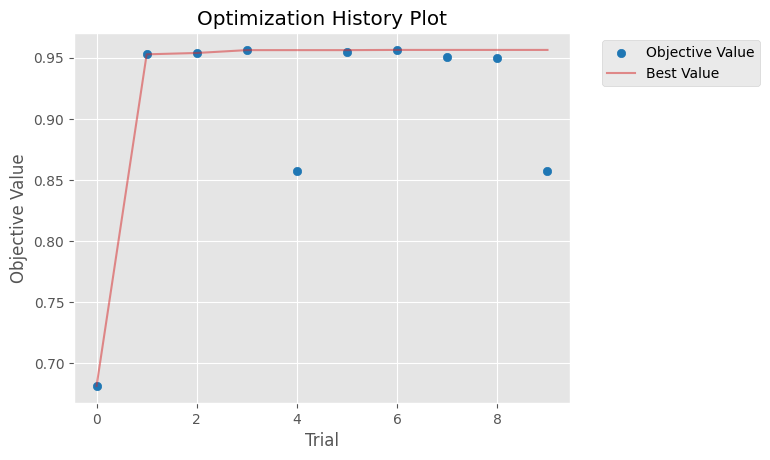

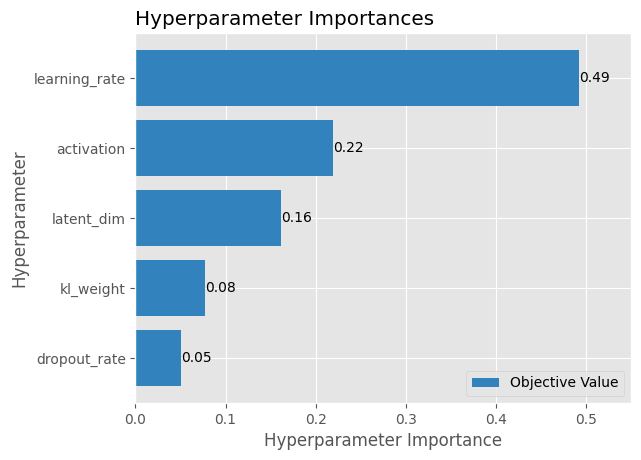

In [66]:
# UAE
axes[0, 0].set_title('UAE Hyperparameter Optimization')
optuna.visualization.matplotlib.plot_optimization_history(study_uvae)
optuna.visualization.matplotlib.plot_param_importances(study_uvae)
fig.show()

## Optuna mit SAE

In [88]:
classifier_dims = [16,8]
# Optimierung nur für SupervisedAE
model_class = SupervisedAE
model_type = 'sae'
model_name = model_class.__name__
print(f"\nStarte Hyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

# Erstelle eine Optuna-Studie
study_sae = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

def objective_sae(trial):
    # Hyperparameter-Suchraum
    latent_dim = trial.suggest_categorical('latent_dim', [2, 8, 16])
    activation = trial.suggest_categorical('activation', ['relu', 'mish', 'swish'])
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)
    l2_lambda = trial.suggest_float('l2_lambda', 0.001, 0.1, log=True)  # L2-Regularisierungsfaktor optimieren
    # Initialisiere ROC-AUC über die Folds
    roc_auc_scores = []

    # StratifiedKFold für robuste Evaluierung
    for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Erstelle und kompiliere das Modell
        model = create_model(model_class,latent_dim,
            classifier_dims=classifier_dims,  # Pass classifier_dims here
            activation=activation,
            dropout_rate=dropout_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        # Baue das Modell
        model.build(input_shape=(None, X_train_fold.shape[1]))
        history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64, validation_data=(X_val_fold, y_val_fold), verbose=0)

        # Berechne Klassifikations-ROC-AUC
        preds = (model.classify(model.encode(tf.convert_to_tensor(X_val_fold, dtype=tf.float32)))>0.5).numpy()
        roc_auc = roc_auc_score(y_val_fold.flatten(), preds)

        roc_auc_scores.append(roc_auc)

    # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
    mean_roc_auc = np.mean(roc_auc_scores)
    return mean_roc_auc
# Führe 20 Trials durch
study_sae.optimize(objective_sae, n_trials=10)

# Speichere die besten Parameter
best_params = study_sae.best_params
best_params_dict[model_name] = best_params
print(f"Beste Parameter für {model_name}: {best_params}")
print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study_sae.best_value:.4f}")

[I 2025-03-02 03:32:27,461] A new study created in memory with name: no-name-e5e6011a-d6e4-4b76-9af6-7ae52001b971



Starte Hyperparameter-Optimierung mit Optuna für SupervisedAE (ROC-AUC mit StratifiedKFold)...


[I 2025-03-02 03:40:00,462] Trial 0 finished with value: 0.8007796147310868 and parameters: {'latent_dim': 8, 'activation': 'relu', 'learning_rate': 0.0030415972814613022, 'dropout_rate': 0.07172045417321903, 'l2_lambda': 0.0029612976444337025}. Best is trial 0 with value: 0.8007796147310868.
[I 2025-03-02 03:47:38,118] Trial 1 finished with value: 0.8490299759109057 and parameters: {'latent_dim': 8, 'activation': 'relu', 'learning_rate': 0.00011881407237894337, 'dropout_rate': 0.005138727211745376, 'l2_lambda': 0.029131633167917795}. Best is trial 1 with value: 0.8490299759109057.
[I 2025-03-02 03:55:02,005] Trial 2 finished with value: 0.7535984595397645 and parameters: {'latent_dim': 2, 'activation': 'swish', 'learning_rate': 0.00011054676055988568, 'dropout_rate': 0.15421772752222093, 'l2_lambda': 0.019860440622427877}. Best is trial 1 with value: 0.8490299759109057.
[I 2025-03-02 04:02:25,294] Trial 3 finished with value: 0.6942631943893278 and parameters: {'latent_dim': 2, 'activ

Beste Parameter für SupervisedAE: {'latent_dim': 8, 'activation': 'relu', 'learning_rate': 0.00011881407237894337, 'dropout_rate': 0.005138727211745376, 'l2_lambda': 0.029131633167917795}
Bester durchschnittlicher ROC-AUC (5-Fold): 0.8490


<ipython-input-89-5ac36d396884>:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

<ipython-input-89-5ac36d396884>:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



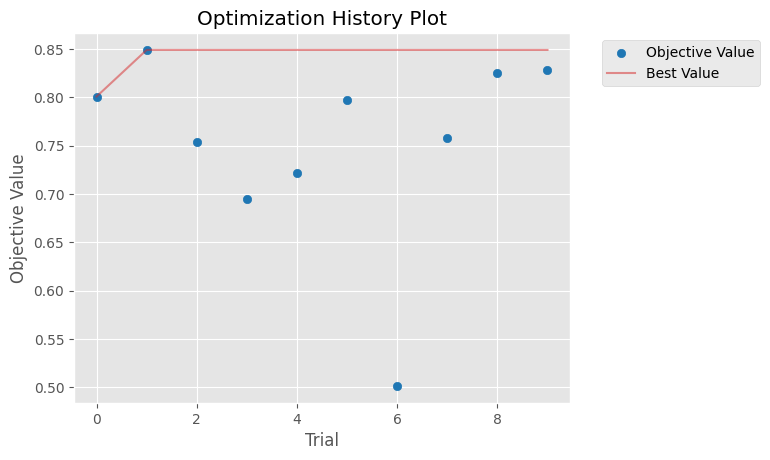

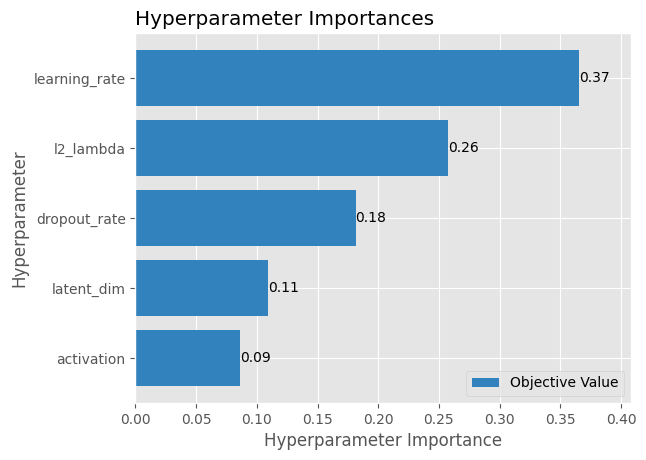

In [89]:
# SAE
axes[0, 0].set_title('SAE Hyperparameter Optimization')
optuna.visualization.matplotlib.plot_optimization_history(study_sae)
optuna.visualization.matplotlib.plot_param_importances(study_sae)
fig.show()

## 1optun SVAE

In [2]:
function ClickConnect(){
    console.log("Working");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ClickConnect,60000)

SyntaxError: invalid syntax (<ipython-input-2-85b9e6e7e494>, line 1)

In [ ]:
classifier_dims = [16,8]
# Optimierung nur für SupervisedAE
model_class = SupervisedVAE
model_type = 'svae'
model_name = model_class.__name__
print(f"\nStarte Hyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

# Erstelle eine Optuna-Studie
study_svae = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

def objective_svae(trial):
    # Hyperparameter-Suchraum
    latent_dim = trial.suggest_categorical('latent_dim', [2, 8, 16])
    activation = trial.suggest_categorical('activation', ['relu', 'mish', 'swish'])
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)
    l2_lambda = trial.suggest_float('l2_lambda', 0.001, 0.1, log=True)  # L2-Regularisierungsfaktor optimieren
    kl_weight = trial.suggest_float('kl_weight', 0.5, 2.0)  # KL-Verlust-Gewicht optimieren
    # Initialisiere ROC-AUC über die Folds
    roc_auc_scores = []

    # StratifiedKFold für robuste Evaluierung
    for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Erstelle und kompiliere das Modell
        model = create_model(model_class,
                             latent_dim=latent_dim,
                    classifier_dims=classifier_dim,
                         activation=activation,
    dropout_rate=dropout_rate,
    kl_weight=kl_weight)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        # Baue das Modell
        model.build(input_shape=(None, X_train_fold.shape[1]))
        history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64, validation_data=(X_val_fold, y_val_fold), verbose=0)

        # Berechne Klassifikations-ROC-AUC
        preds = model.predict(tf.convert_to_tensor(X_val_fold, dtype=tf.float32))[-1]>0.5
        roc_auc = roc_auc_score(y_val_fold.flatten(), preds)

        roc_auc_scores.append(roc_auc)

    # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
    mean_roc_auc = np.mean(roc_auc_scores)
    return mean_roc_auc
# Führe 20 Trials durch
study_svae.optimize(objective_svae, n_trials=10)

# Speichere die besten Parameter
best_params = study_svae.best_params
best_params_dict[model_name] = best_params
print(f"Beste Parameter für {model_name}: {best_params}")
print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study_svae.best_value:.4f}")

[I 2025-03-02 05:17:28,512] A new study created in memory with name: no-name-93538c2f-e583-4045-ab20-e073b264222d



Starte Hyperparameter-Optimierung mit Optuna für SupervisedVAE (ROC-AUC mit StratifiedKFold)...
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


[I 2025-03-02 05:25:27,973] Trial 0 finished with value: 0.6510726988223563 and parameters: {'latent_dim': 16, 'activation': 'swish', 'learning_rate': 0.00021873849926175206, 'dropout_rate': 0.14424332000233736, 'l2_lambda': 0.009614525061319469, 'kl_weight': 1.4421604591568502}. Best is trial 0 with value: 0.6510726988223563.


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


[I 2025-03-02 05:34:40,898] Trial 1 finished with value: 0.612929646521283 and parameters: {'latent_dim': 8, 'activation': 'mish', 'learning_rate': 0.00011435950802931255, 'dropout_rate': 0.08472006428941528, 'l2_lambda': 0.00255209096488252, 'kl_weight': 0.5960651409216224}. Best is trial 0 with value: 0.6510726988223563.


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


[I 2025-03-02 05:44:08,674] Trial 2 finished with value: 0.49999780171466257 and parameters: {'latent_dim': 8, 'activation': 'mish', 'learning_rate': 0.006223525723274393, 'dropout_rate': 0.15307949836782853, 'l2_lambda': 0.005345300594419397, 'kl_weight': 1.3393274498049963}. Best is trial 0 with value: 0.6510726988223563.


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


[I 2025-03-02 05:52:41,918] Trial 3 finished with value: 0.5025236932180908 and parameters: {'latent_dim': 8, 'activation': 'mish', 'learning_rate': 0.006805239094045865, 'dropout_rate': 0.1564356575330514, 'l2_lambda': 0.023359541051925062, 'kl_weight': 0.6243393605377923}. Best is trial 0 with value: 0.6510726988223563.


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


[I 2025-03-02 06:00:32,077] Trial 4 finished with value: 0.6422277140189008 and parameters: {'latent_dim': 2, 'activation': 'mish', 'learning_rate': 0.006298704845914152, 'dropout_rate': 0.09320399916437042, 'l2_lambda': 0.08464093160198653, 'kl_weight': 1.2601738816768508}. Best is trial 0 with value: 0.6510726988223563.


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


[I 2025-03-02 06:08:47,325] Trial 5 finished with value: 0.49999780171466257 and parameters: {'latent_dim': 8, 'activation': 'mish', 'learning_rate': 0.008487388598727611, 'dropout_rate': 0.1628076732974586, 'l2_lambda': 0.038419217008251114, 'kl_weight': 1.374727193560419}. Best is trial 0 with value: 0.6510726988223563.


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


[I 2025-03-02 06:16:28,586] Trial 6 finished with value: 0.7725446802224576 and parameters: {'latent_dim': 8, 'activation': 'relu', 'learning_rate': 0.0003993204715143807, 'dropout_rate': 0.11639387373436641, 'l2_lambda': 0.04854253820807977, 'kl_weight': 1.0118006161907176}. Best is trial 6 with value: 0.7725446802224576.


## Ergebnisse Visualiseren

In [1]:
 #SAE

axes[0, 0].set_title('SAE Hyperparameter Optimization')
optuna.visualization.matplotlib.plot_optimization_history(study_svae)
optuna.visualization.matplotlib.plot_param_importances(study_svae)
fig.show()

NameError: name 'axes' is not defined